In [1]:
import pathlib

import numpy as np
import pandas as pd
import xarray as xr
from scipy import ndimage as ndi
from scipy.stats import binned_statistic, binned_statistic_2d, circmean, circstd
import pyproj

from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date

from tobac_flow.plotting import goes_figure, add_gl_ticks
from tobac_flow.analysis import apply_func_to_labels
from tobac_flow.abi import get_abi_rgb, get_abi_pixel_lengths, get_abi_lat_lon, get_abi_zenith_angle
from tobac_flow.utils import apply_func_to_labels


In [2]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from matplotlib import patches
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [3]:
dpi=300
chapter_name = "chapter3"
save_format = "png"
save_path = pathlib.Path("../figures")
if not save_path.exists():
    save_path.mkdir()

figure_list = []

In [4]:
import scipy as sp
from pyspectral import blackbody
from pyspectral.rsr_reader import RelativeSpectralResponse

data_path = pathlib.Path("../data")
bt_ds = xr.load_dataset(data_path / "pyLRT_anvil_data.nc")

## Plot sensitivity of anvil detection to cirrus at different heights and optical depths

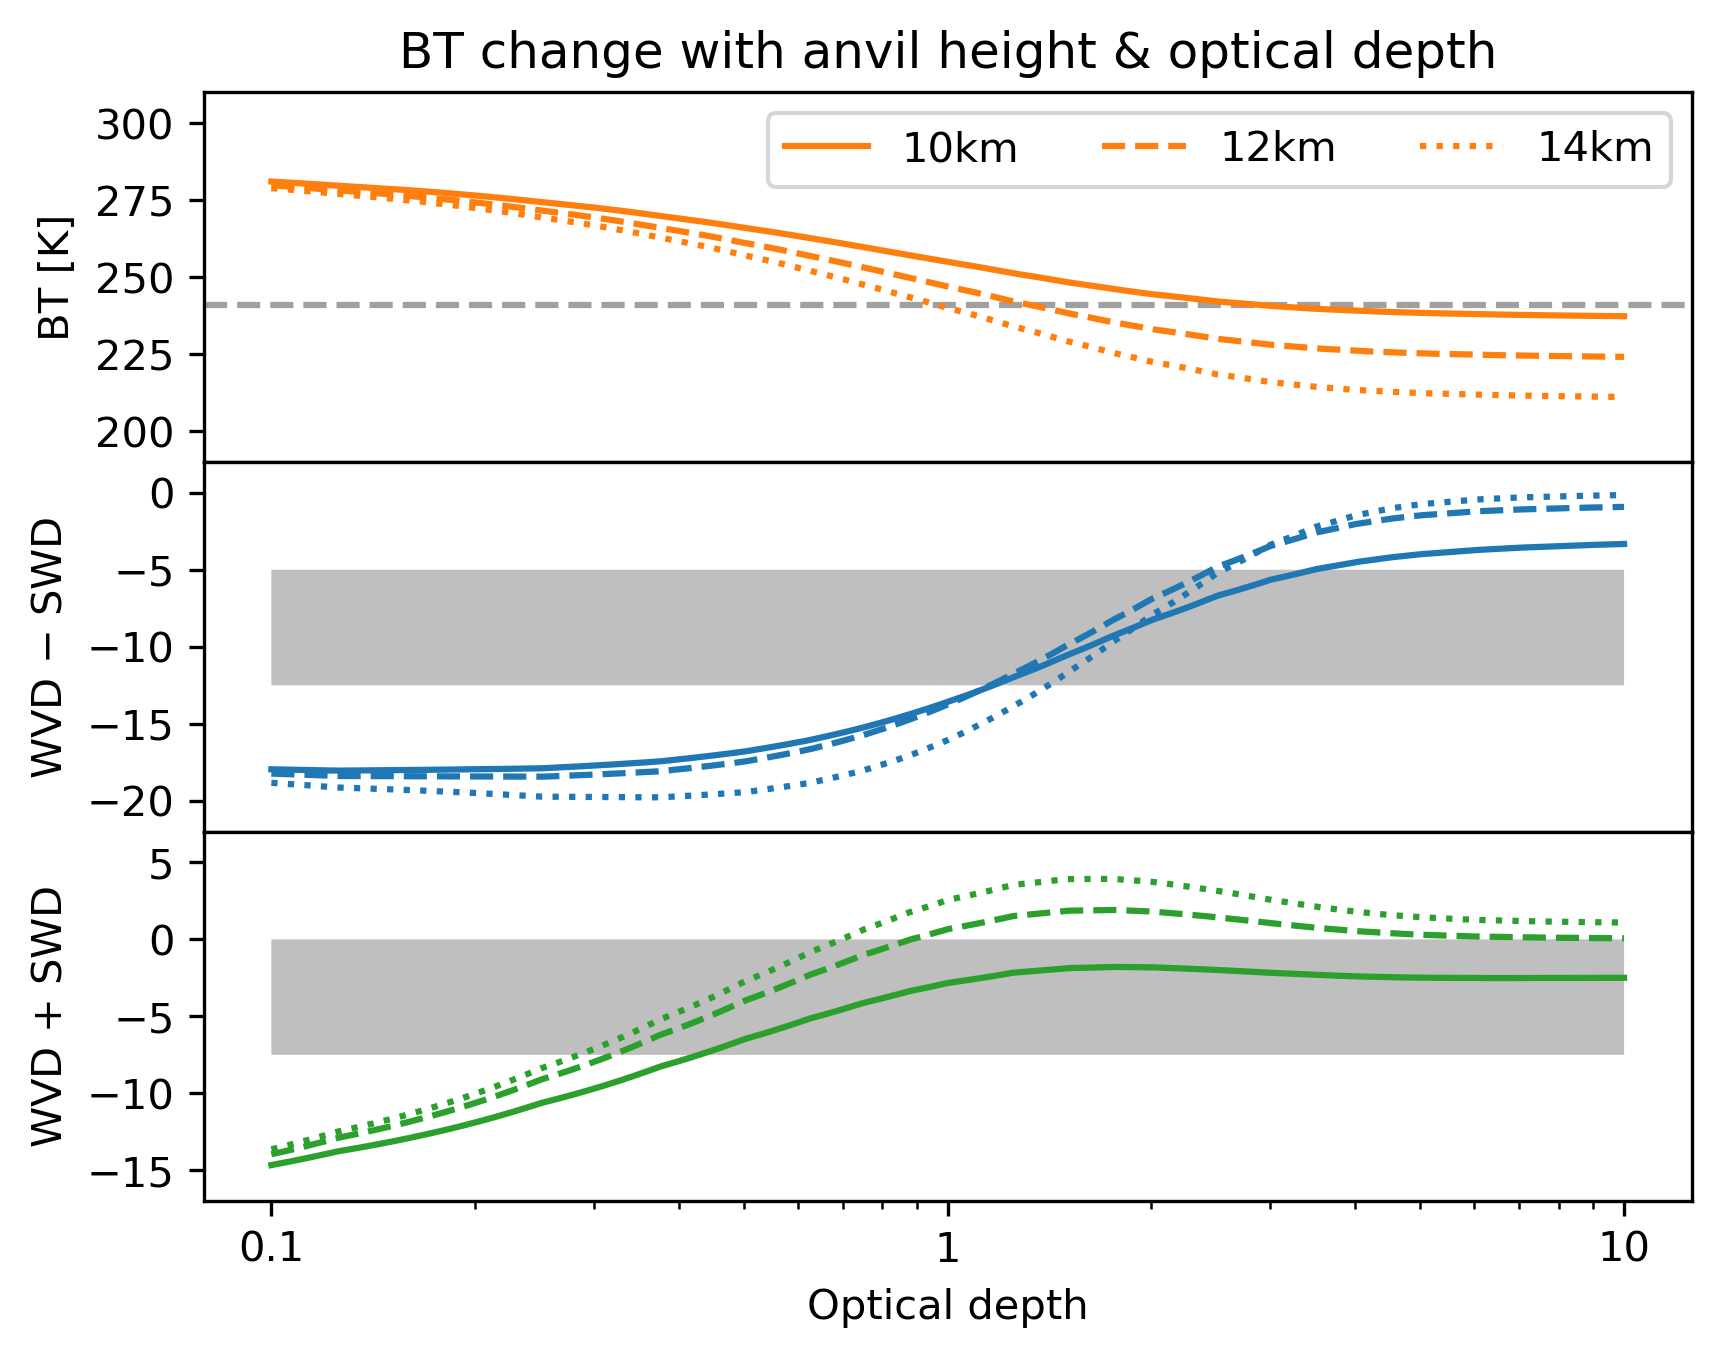

In [5]:
fig, axs = plt.subplots(3, 1, sharex=True, dpi=dpi)
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

xlocs = np.linspace(np.log(0.1), np.log(10), 1000)
xvals = np.minimum(np.exp(xlocs), 10)

abi_rsr = RelativeSpectralResponse('GOES-16', 'abi')

linestyles = ["-", "--", ":"]
for h, height in enumerate(bt_ds.height):
    bt_funcs = [sp.interpolate.interp1d(bt_ds.wavelength.data, bt_ds.clear_sky_bt.data)]
    
    for i in range(bt_ds.optical_depth.size):
        bt_funcs.append(sp.interpolate.interp1d(
            bt_ds.wavelength.data, bt_ds.anvil_bt.sel(height=height)[i]
        ))

    bt_by_channel = {}
    for band in ['ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16']:
        rsr = abi_rsr.rsr[band]["det-1"]
        wavelengths = rsr["wavelength"]/1e6
        srf = rsr["response"]
        bt_by_channel[band] = [np.average(bt(wavelengths), weights=srf) for bt in bt_funcs]

    bt_od_func = {band:sp.interpolate.interp1d(
        [0]+bt_ds.optical_depth.values.tolist(), bt_by_channel[band]
    ) for band in ['ch8','ch10','ch13','ch15']}
    
    wvd_od = bt_od_func["ch8"](xvals) - bt_od_func["ch10"](xvals)
    swd_od = bt_od_func["ch13"](xvals) - bt_od_func["ch15"](xvals)
    axs[0].plot(xlocs, bt_od_func["ch13"](xvals), linestyle=linestyles[h], c="C01")
    axs[1].plot(xlocs, wvd_od - swd_od, linestyle=linestyles[h], c="C00")
    axs[2].plot(xlocs, wvd_od + swd_od, linestyle=linestyles[h], c="C02")
    
# Plot each graph, and manually set the y tick values
axs[0].set_ylabel("BT [K]")
axs[0].legend(["10km", "12km", "14km"], ncol=3)
axs[0].set_ylim([190,310])
axs[0].set_yticks(range(200,301,25))
axs[0].axhline(241, color="grey", ls="--", alpha=0.75, zorder=0)

axs[1].set_ylabel("WVD $-$ SWD")
axs[1].set_yticks(range(-20,1,5))
axs[1].set_ylim([-22,2])
axs[1].fill_between(xlocs, -5, -12.5, color="grey", alpha=0.5, edgecolor="none")
# axs[1].legend(["WVD"], loc="right")

axs[2].set_ylabel("WVD $+$ SWD")
axs[2].set_yticks(range(-15,6,5))
axs[2].set_ylim([-17,7])
axs[2].fill_between(xlocs, 0, -7.5, color="grey", alpha=0.5, edgecolor="none")
# axs[2].legend(["SWD"], loc="right")

axs[0].set_title("BT change with anvil height & optical depth")
plt.xticks([np.log(0.1), np.log(1), np.log(10)], [0.1, 1, 10])
plt.xticks(np.log(np.arange(0.1,1,0.1)).tolist() + np.log(np.arange(1,11,1)).tolist(), minor=True)
plt.xlabel("Optical depth")

figure_list.append(plt.gcf())

Load DCC statistics and extract required variables

In [6]:
dcc_path = pathlib.Path("../data/goes_statistics")
dcc_files = sorted(list(dcc_path.glob("dcc_statistics_G16_*.nc")))
print(len(dcc_files))
datasets = [xr.open_dataset(f) for f in dcc_files]

60


In [7]:
anvil_lat = np.concatenate([ds.thick_anvil_average_lat.data for ds in datasets])
anvil_lon = np.concatenate([ds.thick_anvil_average_lon.data for ds in datasets])
anvil_start_lat = np.concatenate([ds.thick_anvil_start_lat.data for ds in datasets])
anvil_start_lon = np.concatenate([ds.thick_anvil_start_lon.data for ds in datasets])
def anvil_initiation_t(ds):
    return np.minimum(
        ds.core_start_t.loc[ds.anvil_initial_core_index.data].data, 
        ds.thick_anvil_start_t.data
    )
    
anvil_start_t = np.concatenate([anvil_initiation_t(ds) for ds in datasets])
anvil_month = (anvil_start_t.astype("datetime64[M]") - anvil_start_t.astype("datetime64[Y]")).astype("timedelta64[M]").astype(int) + 1

In [8]:
anvil_is_valid = np.concatenate([ds.thin_anvil_is_valid.data for ds in datasets])
thin_anvil_valid_start = np.concatenate([
    (ds.thin_anvil_start_t.data >= ds.thick_anvil_start_t.data) 
    & (ds.thin_anvil_start_t.data >= anvil_initiation_t(ds))
    for ds in datasets
])

anvil_is_valid = np.logical_and.reduce([
    anvil_is_valid,
    thin_anvil_valid_start,
    anvil_start_lon > -110,
    anvil_start_lat < 45
])

print(np.sum(anvil_is_valid), anvil_is_valid.size)

391050 648345


In [9]:
anvil_number_of_cores = np.concatenate([ds.anvil_core_count.data for ds in datasets])

print(np.sum(anvil_number_of_cores[anvil_is_valid]), np.sum(anvil_number_of_cores))

792522 1705851


In [10]:
anvil_number_of_cores = np.concatenate([ds.anvil_core_count.data for ds in datasets])

anvil_max_area = np.concatenate([ds.thick_anvil_max_area.data for ds in datasets])
thin_anvil_max_area = np.concatenate([ds.thin_anvil_max_area.data for ds in datasets])

anvil_total_area = np.concatenate([ds.thick_anvil_total_area.data for ds in datasets])
thin_anvil_total_area = np.concatenate([ds.thin_anvil_total_area.data for ds in datasets])

anvil_lifetime = np.concatenate([ds.thick_anvil_lifetime.data for ds in datasets]).astype("timedelta64[s]").astype(int)/3600

anvil_ctt_mean = np.concatenate([ds.thick_anvil_BT_mean.data for ds in datasets])
anvil_ctt_min = np.concatenate([ds.thick_anvil_BT_min.data for ds in datasets])

initial_core_cooling_rate = np.concatenate([ds.core_cooling_rate.loc[ds.anvil_initial_core_index].data for ds in datasets])


In [11]:
anvil_time_to_min_BT = np.concatenate([ds.thick_anvil_min_BT_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
anvil_time_to_max_thick_area = np.concatenate([ds.thick_anvil_max_area_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
anvil_time_to_max_thin_area = np.concatenate([ds.thin_anvil_max_area_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
thick_anvil_lifetime = np.concatenate([ds.thick_anvil_end_t.data - anvil_initiation_t(ds)for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
thin_anvil_lifetime = np.concatenate([ds.thin_anvil_end_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600


## Example of modified del Genio method for lifecycle stages

<xarray.DataArray 'thin_anvil_is_valid' ()> Size: 1B
array(True)
Coordinates:
    anvil    int32 4B 25954
    x_image  float32 4B ...
    y_image  float32 4B ...


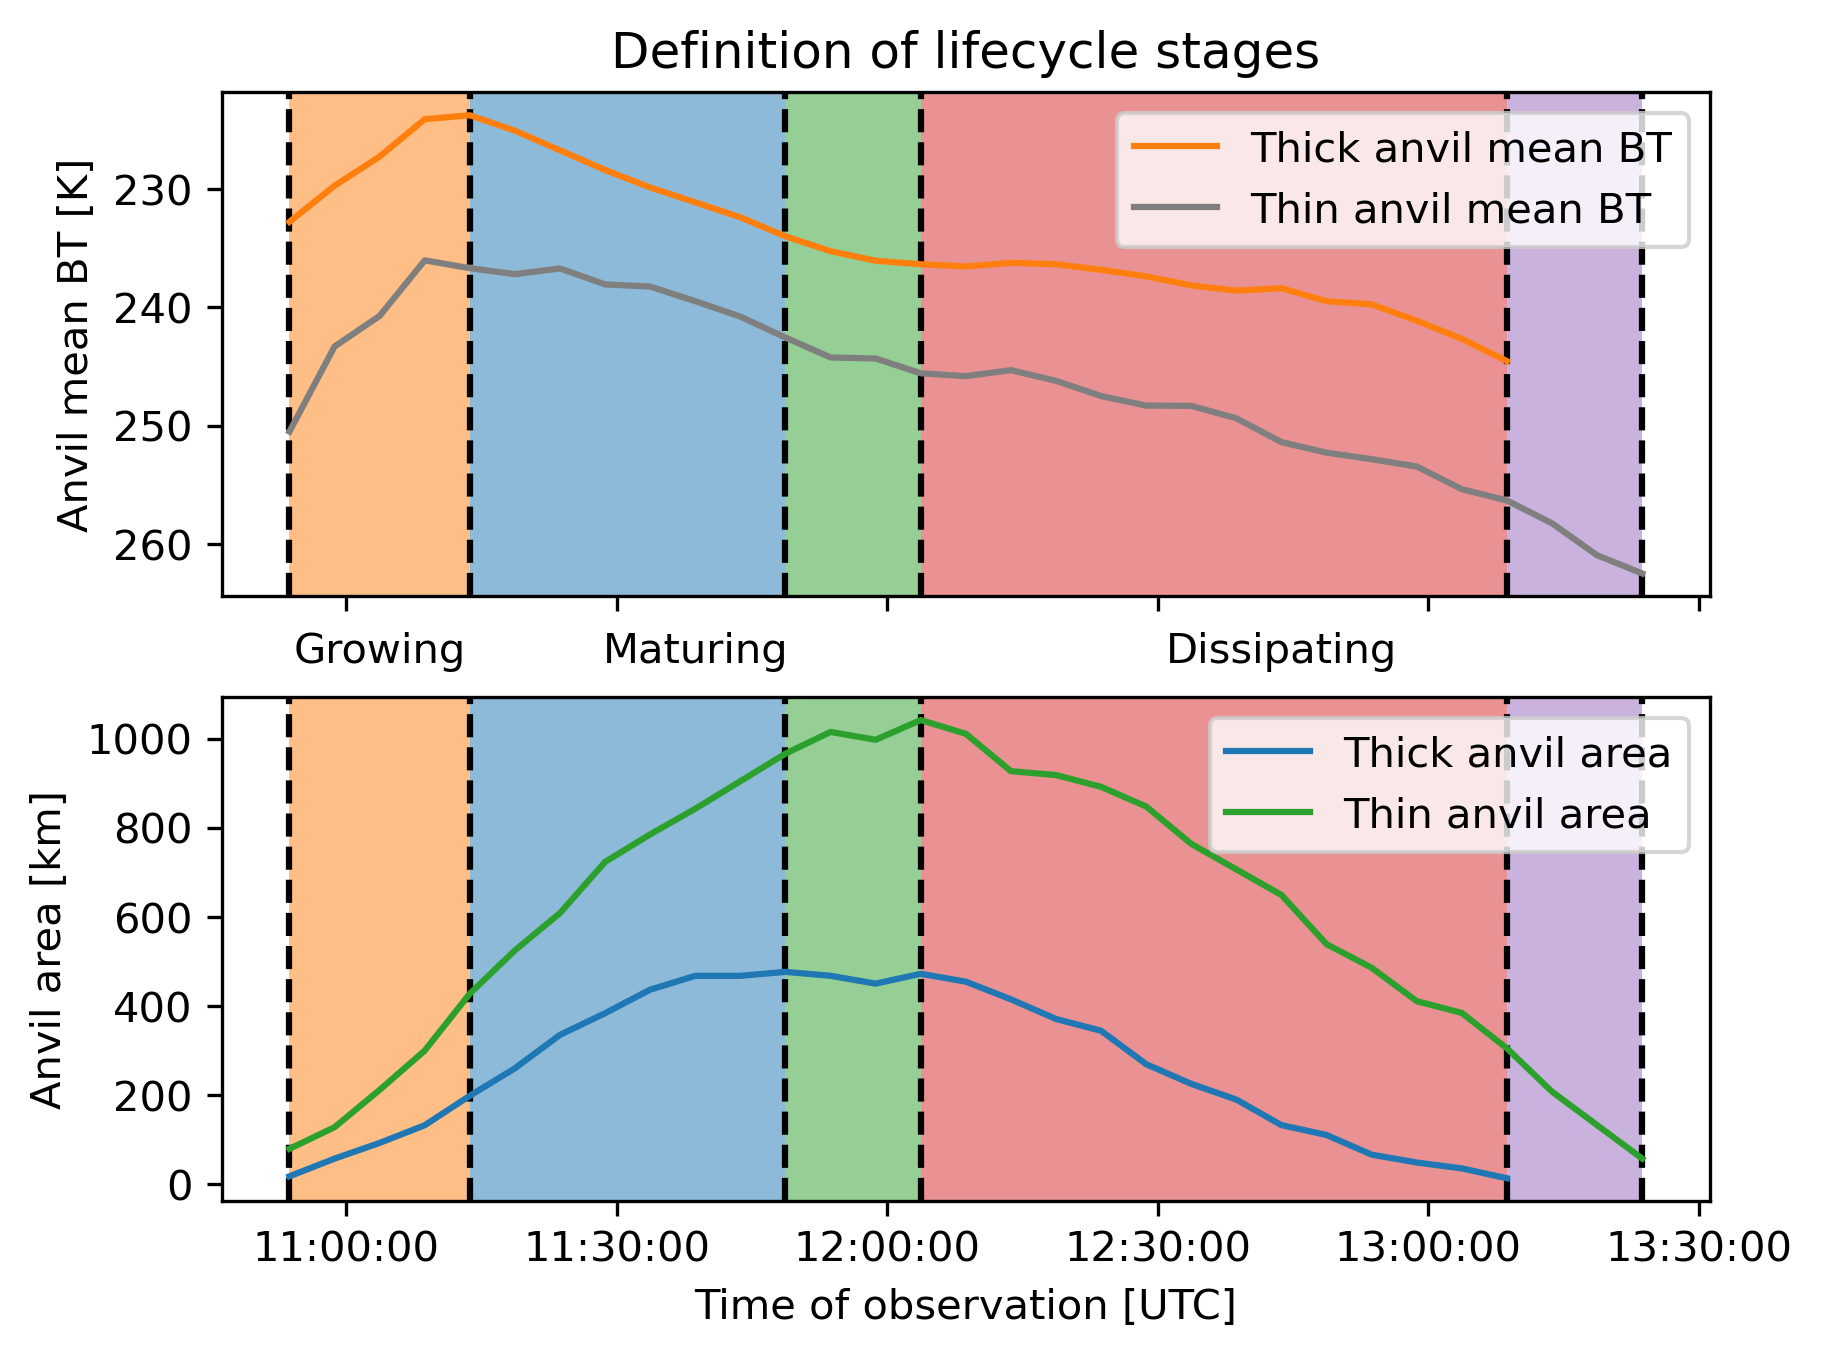

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=dpi)
# Remove vertical space between axes
fig.subplots_adjust(hspace=0.2)

anvil = datasets[5].anvil.data[9007]
print(datasets[5].thin_anvil_is_valid.loc[anvil])
l1 = ax1.plot(
    datasets[5].thick_anvil_step_t[datasets[5].thick_anvil_step_anvil_index==anvil],
    datasets[5].thick_anvil_step_BT_mean.data[datasets[5].thick_anvil_step_anvil_index==anvil],
    color="C1", linestyle="-", linewidth=1.5, zorder=3
)
l2 = ax1.plot(
    datasets[5].thin_anvil_step_t[datasets[5].thin_anvil_step_anvil_index==anvil],
    datasets[5].thin_anvil_step_BT_mean.data[datasets[5].thin_anvil_step_anvil_index==anvil],
    color="C7", linestyle="-", linewidth=1.5, zorder=3
)
ax1.invert_yaxis()
ax1.legend([l1[0], l2[0]], ["Thick anvil mean BT", "Thin anvil mean BT"])

l3 = ax2.plot(
    datasets[5].thick_anvil_step_t[datasets[5].thick_anvil_step_anvil_index==anvil],
    datasets[5].thick_anvil_step_area.data[datasets[5].thick_anvil_step_anvil_index==anvil],
    color="C0", linestyle="-", linewidth=1.5, zorder=3
)
l4 = ax2.plot(
    datasets[5].thin_anvil_step_t[datasets[5].thin_anvil_step_anvil_index==anvil],
    datasets[5].thin_anvil_step_area.data[datasets[5].thin_anvil_step_anvil_index==anvil],
    color="C2", linestyle="-", linewidth=1.5, zorder=3
)
ax2.legend([l3[0], l4[0]], ["Thick anvil area", "Thin anvil area"])

for ax in [ax1, ax2]:
    ax.axvspan(
        datasets[5].thick_anvil_start_t.loc[anvil].data, datasets[5].thick_anvil_min_BT_t.loc[anvil].data, 
        facecolor="C1", alpha=0.5
    )
    ax.axvspan(
        datasets[5].thick_anvil_min_BT_t.loc[anvil].data, datasets[5].thick_anvil_max_area_t.loc[anvil].data, 
        facecolor="C0", alpha=0.5
    )
    ax.axvspan(
        datasets[5].thick_anvil_max_area_t.loc[anvil].data, datasets[5].thin_anvil_max_area_t.loc[anvil].data, 
        facecolor="C2", alpha=0.5
    )
    ax.axvspan(
        datasets[5].thin_anvil_max_area_t.loc[anvil].data, datasets[5].thick_anvil_end_t.loc[anvil].data, 
        facecolor="C3", alpha=0.5
    )
    ax.axvspan(
        datasets[5].thick_anvil_end_t.loc[anvil].data, datasets[5].thin_anvil_end_t.loc[anvil].data, 
        facecolor="C4", alpha=0.5
    )

    
    ax.axvline(datasets[5].thick_anvil_start_t.loc[anvil].data, color='k', linestyle="--", linewidth=1.5)
    ax.axvline(datasets[5].thick_anvil_min_BT_t.loc[anvil].data, color='k', linestyle="--", linewidth=1.5)
    ax.axvline(datasets[5].thick_anvil_max_area_t.loc[anvil].data, color='k', linestyle="--", linewidth=1.5)
    ax.axvline(datasets[5].thin_anvil_max_area_t.loc[anvil].data, color='k', linestyle="--", linewidth=1.5)
    ax.axvline(datasets[5].thick_anvil_end_t.loc[anvil].data, color='k', linestyle="--", linewidth=1.5)
    ax.axvline(datasets[5].thin_anvil_end_t.loc[anvil].data, color='k', linestyle="--", linewidth=1.5)
    
ax1.set_title("Definition of lifecycle stages")
ax1.set_ylabel("Anvil mean BT [K]")
ax2.set_ylabel("Anvil area [km]")
ax2.set_xlabel("Time of observation [UTC]")
import matplotlib.dates as mdates
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

ax1.text(
    datasets[5].thick_anvil_start_t.loc[anvil].data 
    + (datasets[5].thick_anvil_min_BT_t.loc[anvil].data-datasets[5].thick_anvil_start_t.loc[anvil].data)/2,
    270, "Growing", ha="center"
)
ax1.text(
    datasets[5].thick_anvil_min_BT_t.loc[anvil].data 
    + (datasets[5].thin_anvil_max_area_t.loc[anvil].data-datasets[5].thick_anvil_min_BT_t.loc[anvil].data)/2,
    270, "Maturing", ha="center"
)
ax1.text(
    datasets[5].thin_anvil_max_area_t.loc[anvil].data 
    + (datasets[5].thin_anvil_end_t.loc[anvil].data-datasets[5].thin_anvil_max_area_t.loc[anvil].data)/2,
    270, "Dissipating", ha="center"
)

figure_list.append(plt.gcf())

In [13]:
composites_path = pathlib.Path("../data/chapter_3_data/interpolated_anvil_areas/")

interpolated_areas = [xr.open_dataset(f) for f in sorted(list(composites_path.glob("interpolated_*.nc")))]

In [14]:
interp_core_areas = np.concatenate([ds.interp_core_area.values for ds in interpolated_areas], 0)
interp_thick_areas = np.concatenate([ds.interp_thick_area.values for ds in interpolated_areas], 0)
interp_thin_areas = np.concatenate([ds.interp_thin_area.values for ds in interpolated_areas], 0)
interp_total_areas = np.concatenate([ds.interp_total_area.values for ds in interpolated_areas], 0)


In [15]:
wh_invalid_total = interp_total_areas == 0
replacements = np.maximum(interp_core_areas[wh_invalid_total], interp_thick_areas[wh_invalid_total])
interp_total_areas[wh_invalid_total] = replacements
interp_thin_areas[wh_invalid_total] = replacements


In [16]:
interp_core_areas.shape

(648345, 101)

## Example composite area and proportions

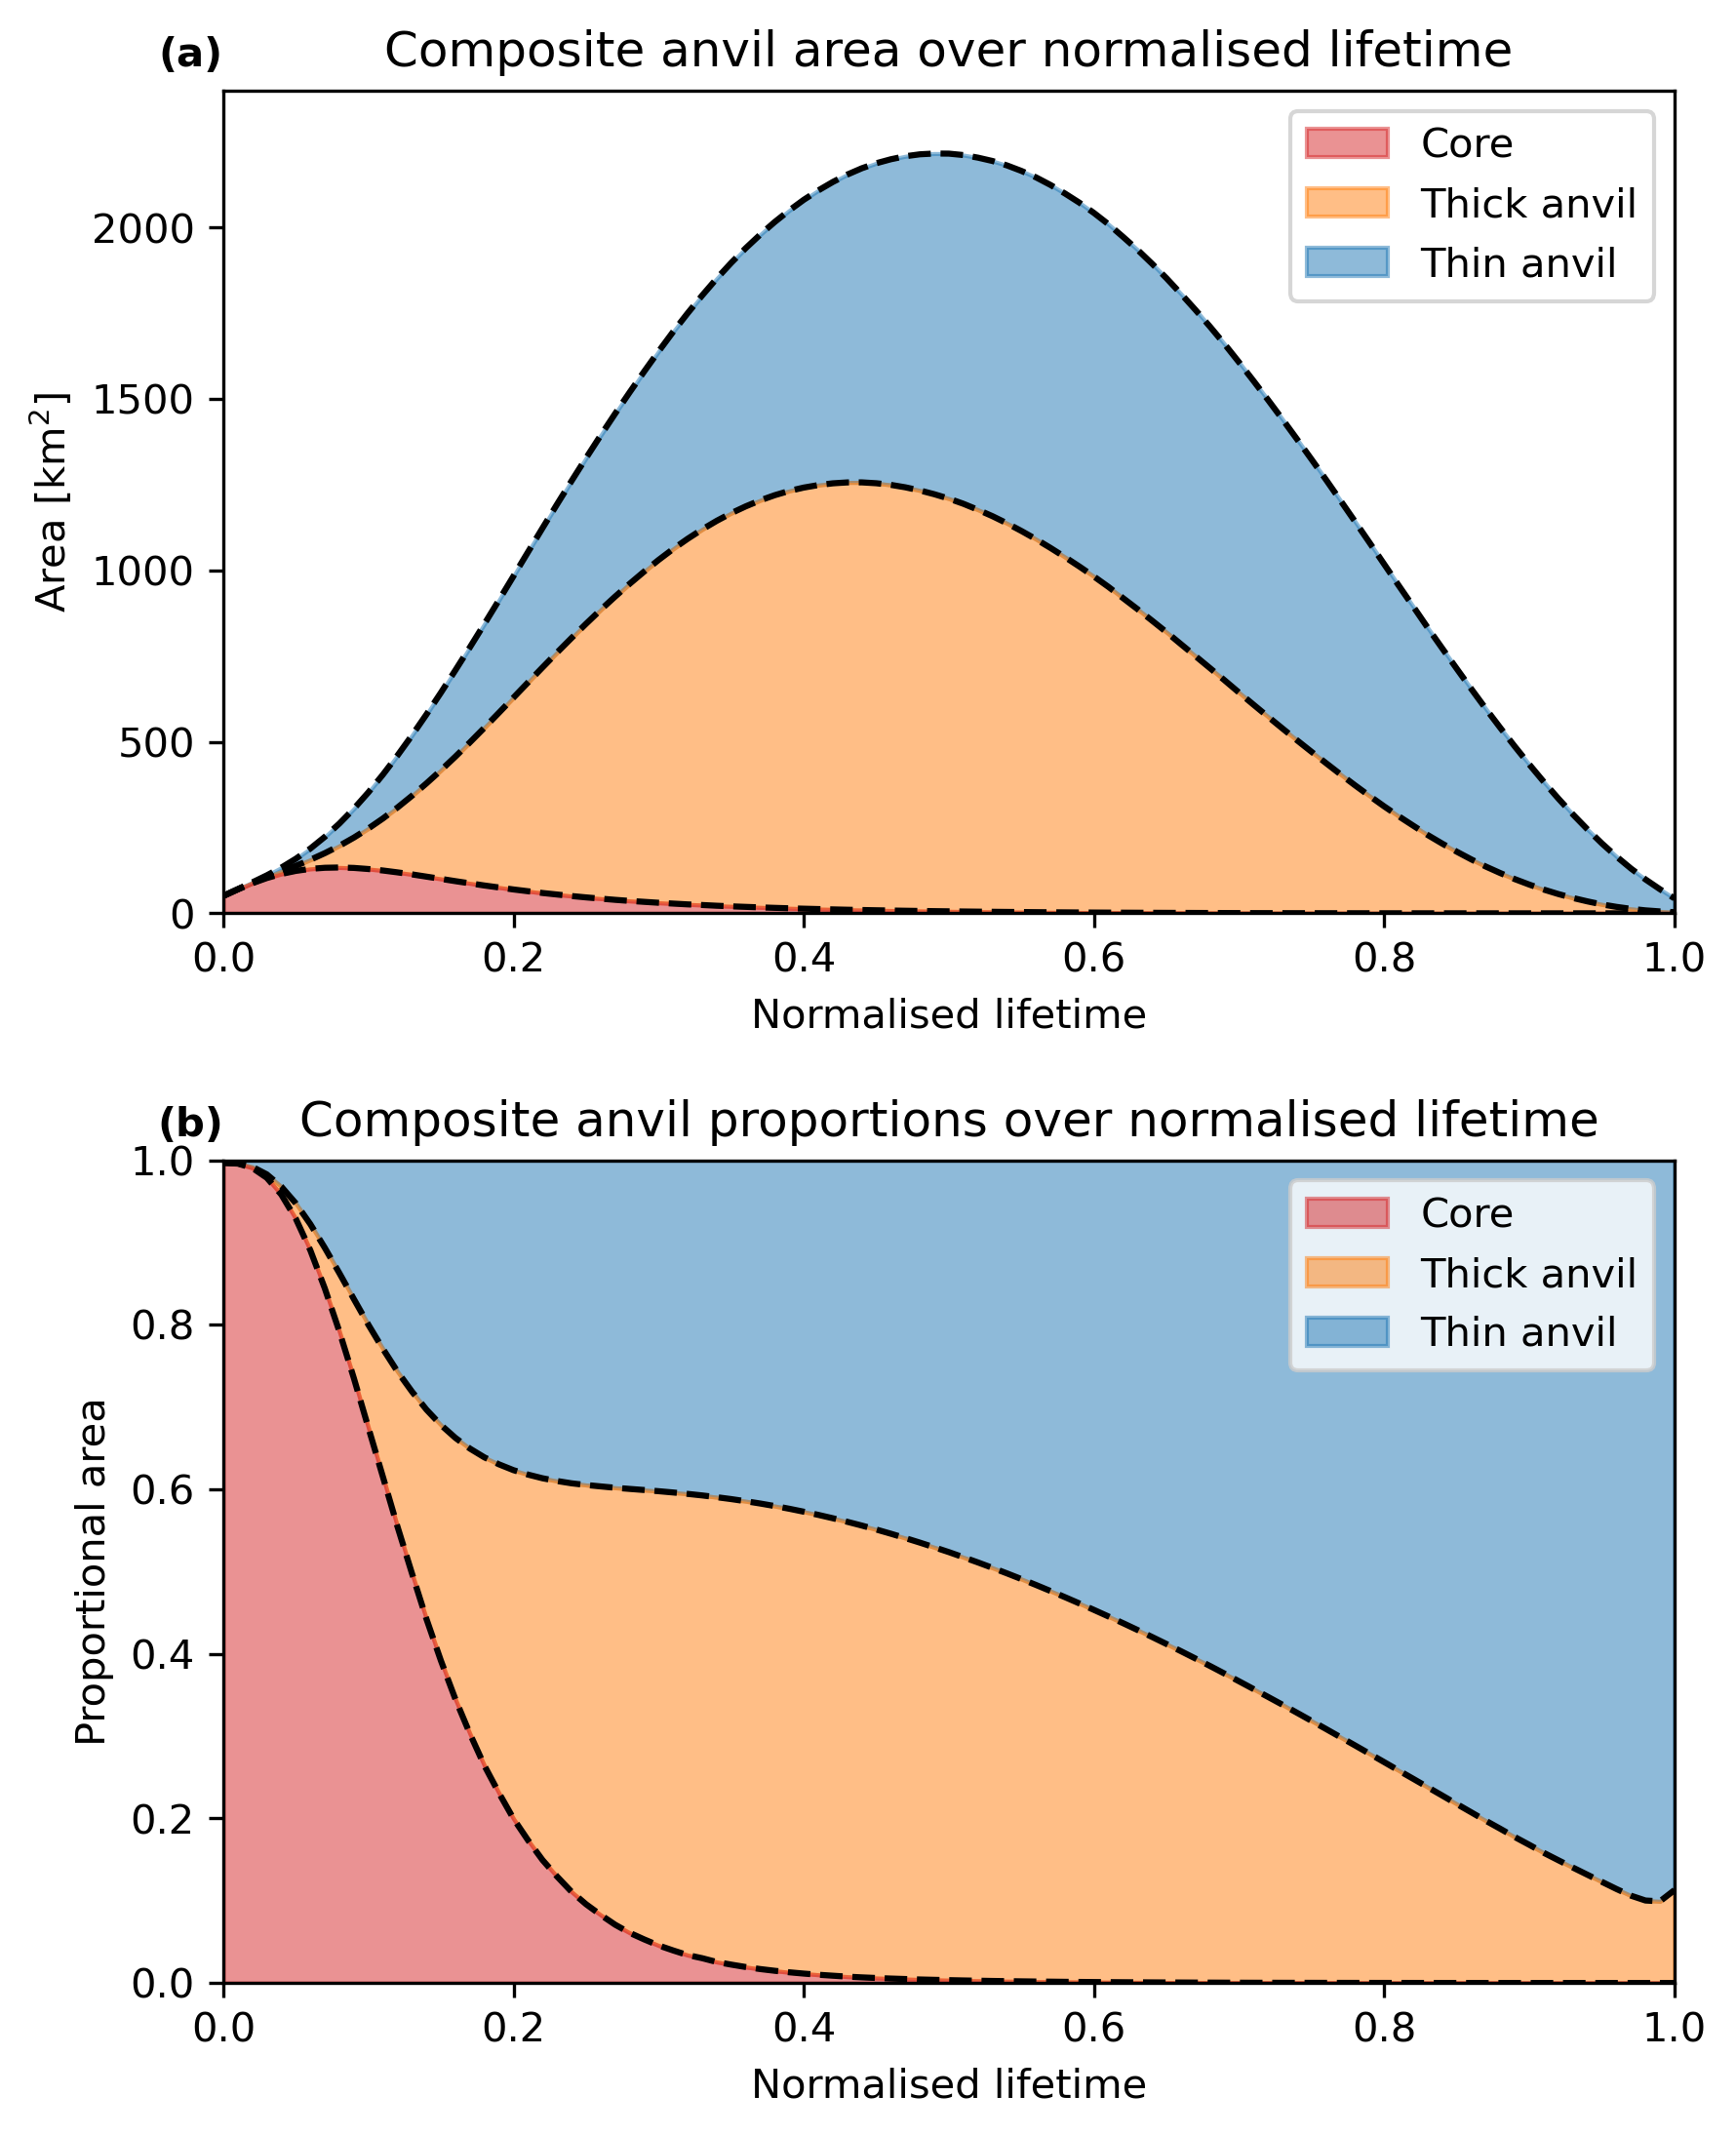

In [17]:
plt.figure(dpi=dpi, figsize=(6.4,8.4))

plt.subplot(211)

thin_fill = plt.fill_between(
    interpolated_areas[0]["interp"], 
    np.maximum(interp_thick_areas, interp_core_areas)[anvil_is_valid].mean(0), 
    np.maximum(interp_thin_areas, interp_core_areas)[anvil_is_valid].mean(0), 
    color="C0", alpha=0.5,
)
thick_fill = plt.fill_between(
    interpolated_areas[0]["interp"], 
    interp_core_areas[anvil_is_valid].mean(0), 
    np.maximum(interp_thick_areas, interp_core_areas)[anvil_is_valid].mean(0), 
    color="C1", alpha=0.5,
)
core_fill = plt.fill_between(
    interpolated_areas[0]["interp"], 
    interp_core_areas[anvil_is_valid].mean(0), 
    color="C3", alpha=0.5,
)
plt.plot(
    interpolated_areas[0]["interp"], 
    np.maximum(interp_thin_areas, interp_core_areas)[anvil_is_valid].mean(0), 
    "k--"
)
plt.plot(
    interpolated_areas[0]["interp"], 
    np.maximum(interp_thick_areas, interp_core_areas)[anvil_is_valid].mean(0), 
    "k--"
)
plt.plot(
    interpolated_areas[0]["interp"], 
    interp_core_areas[anvil_is_valid].mean(0), 
    "k--"
)
plt.ylim([0,2400])
plt.xlim([0,1])
plt.legend([core_fill, thick_fill, thin_fill], ["Core", "Thick anvil", "Thin anvil"])

plt.xlabel("Normalised lifetime")
plt.ylabel("Area [$\mathrm{km^{2}}$]")
plt.title("Composite anvil area over normalised lifetime")
plt.title("(a)", loc="left", ha="right", weight="bold", fontsize=10)

plt.subplot(212)

thin_fill = plt.fill_between(
    interpolated_areas[0]["interp"], 
    np.nanmean((np.maximum(interp_thick_areas, interp_core_areas)/interp_total_areas)[anvil_is_valid], 0), 
    np.nanmean((np.maximum(interp_thin_areas, interp_core_areas)/interp_total_areas)[anvil_is_valid], 0), 
    color="C0", alpha=0.5,
)
thick_fill = plt.fill_between(
    interpolated_areas[0]["interp"], 
    np.nanmean((interp_core_areas/interp_total_areas)[anvil_is_valid], 0), 
    np.nanmean((np.maximum(interp_thick_areas, interp_core_areas)/interp_total_areas)[anvil_is_valid], 0), 
    color="C1", alpha=0.5,
)
core_fill = plt.fill_between(
    interpolated_areas[0]["interp"], 
    np.nanmean((interp_core_areas/interp_total_areas)[anvil_is_valid], 0), 
    color="C3", alpha=0.5,
)
plt.plot(
    interpolated_areas[0]["interp"], 
    np.nanmean((np.maximum(interp_thick_areas, interp_core_areas)/interp_total_areas)[anvil_is_valid], 0),
    "k--"
)
plt.plot(
    interpolated_areas[0]["interp"], 
    np.nanmean((interp_core_areas/interp_total_areas)[anvil_is_valid], 0), 
    "k--"
)
plt.ylim([0,1])
plt.xlim([0,1])
plt.legend([core_fill, thick_fill, thin_fill], ["Core", "Thick anvil", "Thin anvil"])

plt.xlabel("Normalised lifetime")
plt.ylabel("Proportional area")
plt.title("Composite anvil proportions over normalised lifetime")
plt.title("(b)", loc="left", ha="right", weight="bold", fontsize=10)

plt.subplots_adjust(hspace=0.3)

figure_list.append(plt.gcf())

## Plot thin anvil proportion vs anvil BT, cooling rate and number of cores

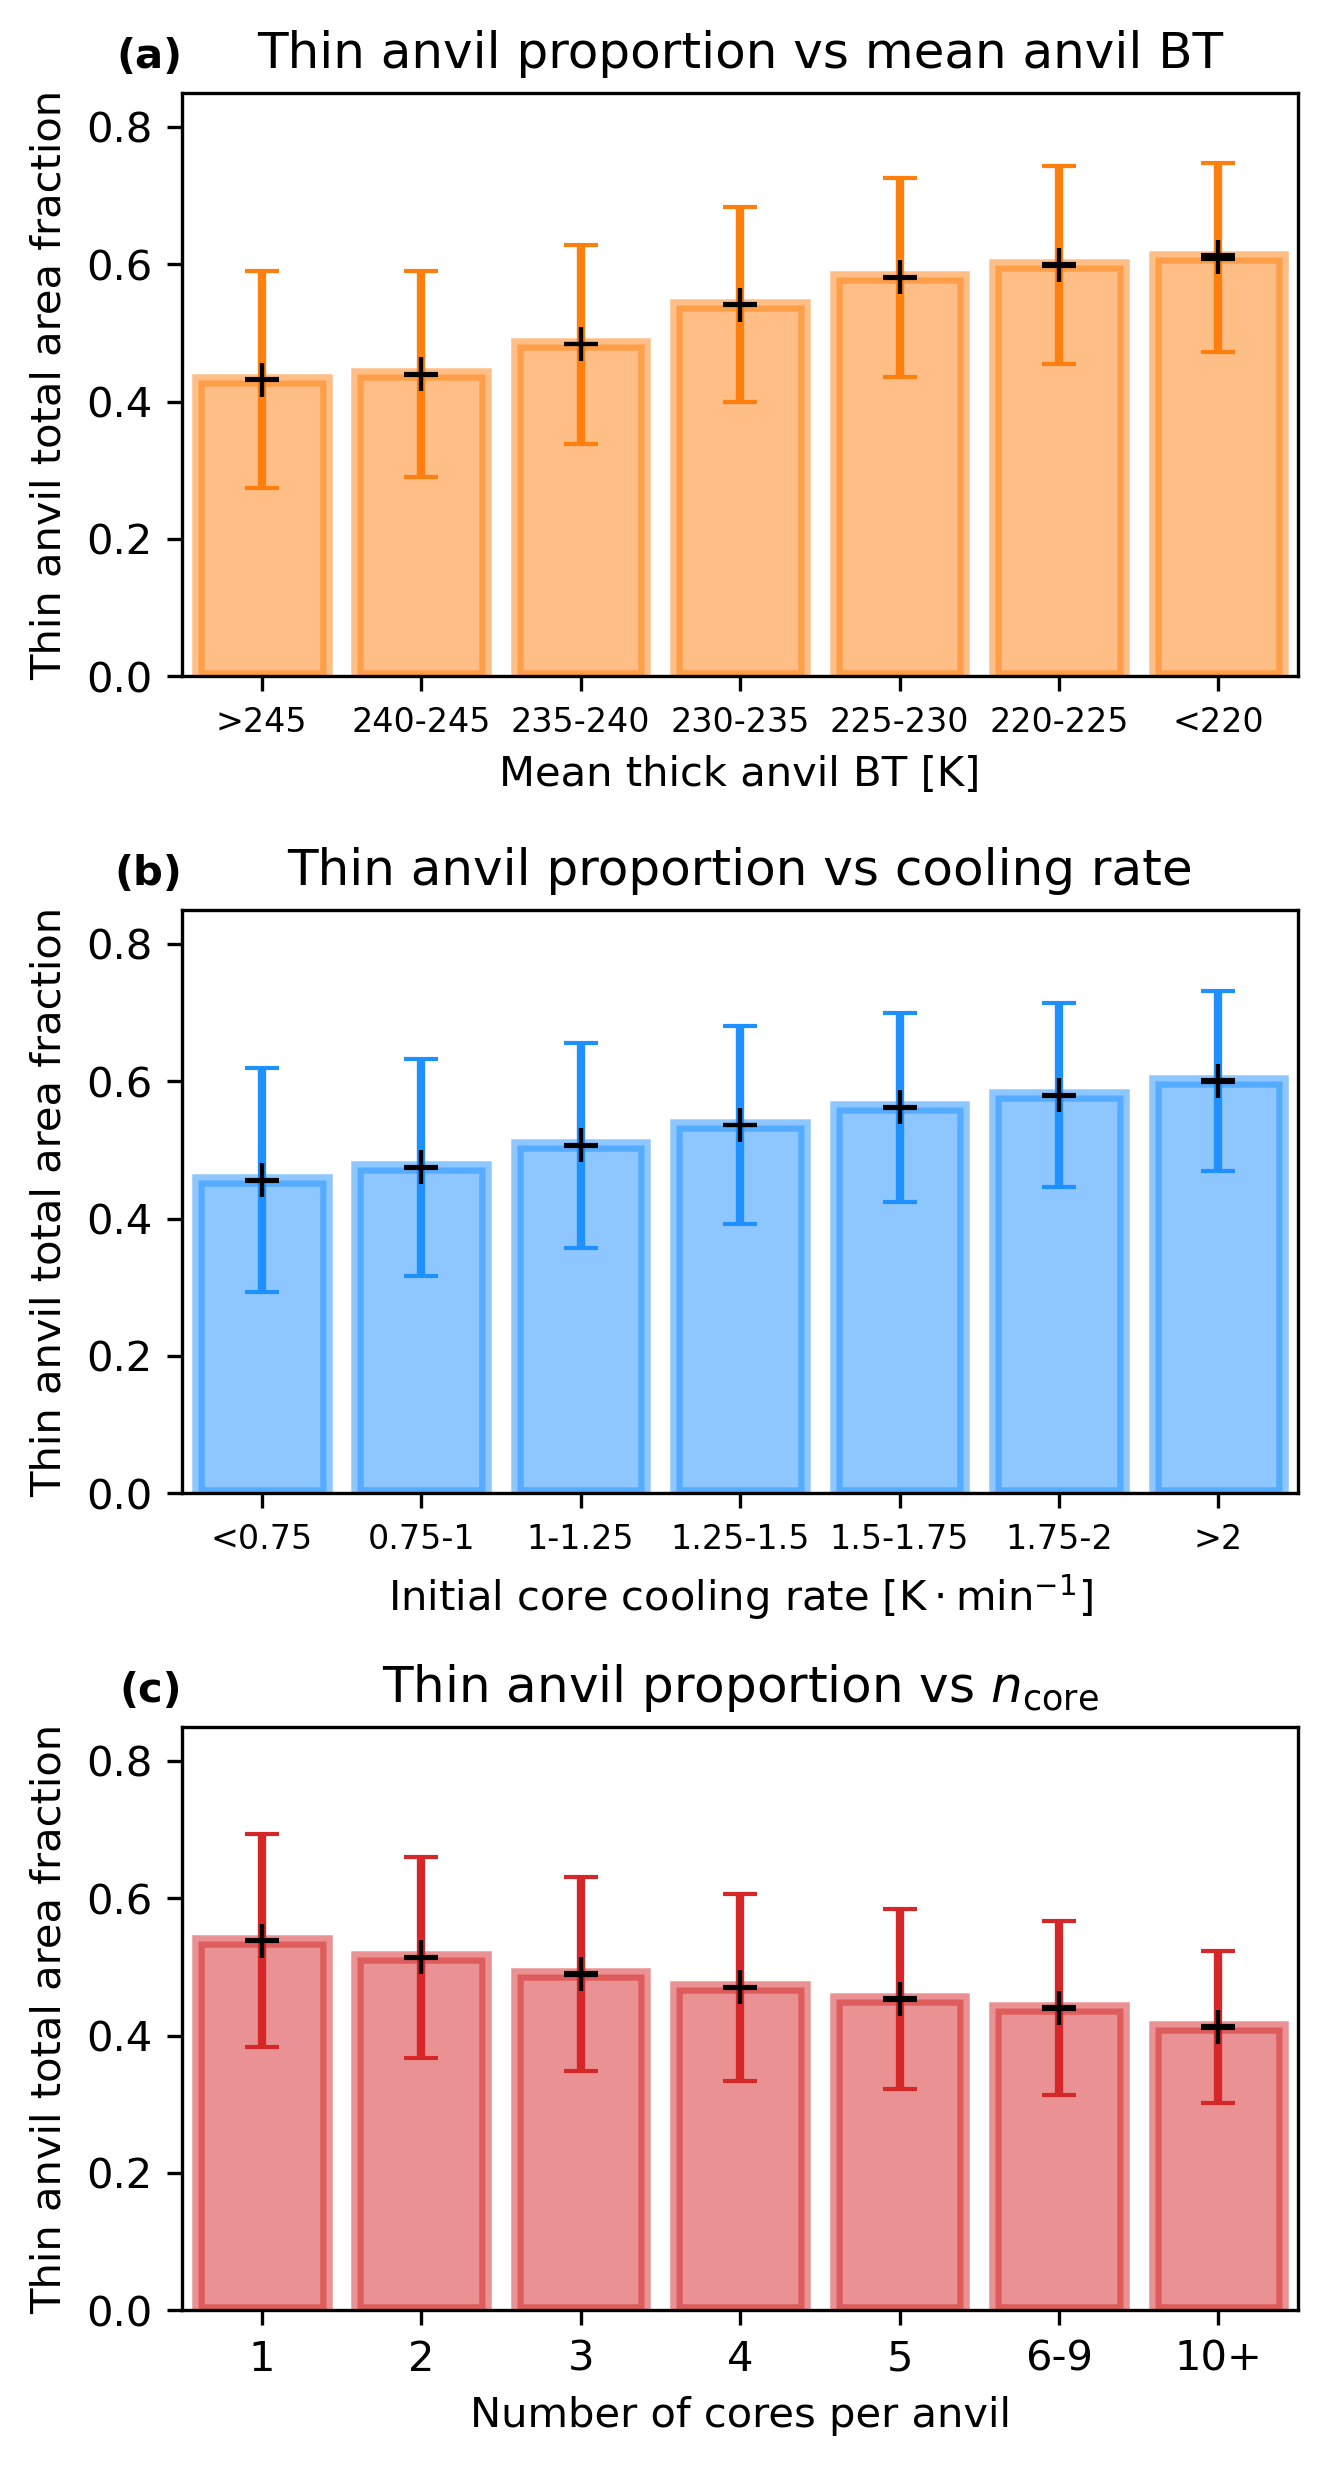

In [18]:
plt.figure(dpi=dpi, figsize=(4.8,9.6))

anvil_area_prop = 1 - (anvil_total_area / thin_anvil_total_area)

ax = plt.subplot(311)

ctt_bins = [190,220,225,230,235,240,245,270]
ctt_labels = [f"{ctt_bins[i]}-{ctt_bins[i+1]}" if 0<i<(len(ctt_bins)-2) 
              else f"<{ctt_bins[i+1]}" if i == 0 else f">{ctt_bins[i]}"
              for i in range(len(ctt_bins)-1)]

bar_data = binned_statistic(
    anvil_ctt_mean[anvil_is_valid], 
    anvil_area_prop[anvil_is_valid], 
    bins=ctt_bins, 
    statistic="mean"
)
errorbar_data = binned_statistic(
    anvil_ctt_mean[anvil_is_valid], 
    anvil_area_prop[anvil_is_valid], 
    bins=ctt_bins, 
    statistic="std"
)
counts = np.histogram(anvil_ctt_mean[anvil_is_valid], bins=ctt_bins)

errorbars = errorbar_data[0]

plt.bar(np.arange(len(ctt_bins)-1), bar_data[0], 
        alpha=0.5, facecolor = 'C1', edgecolor='C1', ls='solid', lw=3)
plt.errorbar(np.arange(len(ctt_bins)-1), bar_data[0], errorbars, 0, 
             color="C1", linestyle="", capsize=4, linewidth=2)
plt.errorbar(np.arange(len(ctt_bins)-1), bar_data[0], errorbars / (counts[0])**0.5, 0, 
             color="k", linestyle="", capsize=4)

plt.xticks(np.arange(len(ctt_bins)-1), ctt_labels, fontsize=8)
plt.xlim([-0.5,6.5])
plt.ylim([0.,0.85])
plt.xlabel("Mean thick anvil BT [K]")
plt.ylabel("Thin anvil total area fraction")
plt.title("Thin anvil proportion vs mean anvil BT")
ax.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)

plt.gca().invert_xaxis()

ax = plt.subplot(312)

anvil_cooling_bins = [0,0.75,1,1.25,1.5,1.75,2,10]
anvil_cooling_labels = [f"{anvil_cooling_bins[i]}-{anvil_cooling_bins[i+1]}" if 0<i<(len(anvil_cooling_bins)-2) 
              else f"<{anvil_cooling_bins[i+1]}" if i == 0 else f">{anvil_cooling_bins[i]}"
              for i in range(len(ctt_bins)-1)]

bar_data = binned_statistic(
    initial_core_cooling_rate[anvil_is_valid], 
    anvil_area_prop[anvil_is_valid], 
    bins=anvil_cooling_bins, 
    statistic="mean"
)
errorbar_data = binned_statistic(
    initial_core_cooling_rate[anvil_is_valid], 
    anvil_area_prop[anvil_is_valid], 
    bins=anvil_cooling_bins, 
    statistic="std"
)
counts = np.histogram(initial_core_cooling_rate[anvil_is_valid], bins=anvil_cooling_bins)

errorbars = errorbar_data[0]

plt.bar(np.arange(len(ctt_bins)-1), bar_data[0], 
        alpha=0.5, facecolor = 'dodgerblue', edgecolor='dodgerblue', ls='solid', lw=3)
plt.errorbar(np.arange(len(anvil_cooling_bins)-1), bar_data[0], errorbars, 0, 
             color="dodgerblue", linestyle="", capsize=4, linewidth=2)
plt.errorbar(np.arange(len(anvil_cooling_bins)-1), bar_data[0], errorbars / (counts[0])**0.5, 0, 
             color="k", linestyle="", capsize=4)

plt.xticks(np.arange(len(anvil_cooling_bins)-1), anvil_cooling_labels, fontsize=8)
plt.xlim([-0.5,6.5])
plt.ylim([0.,0.85])
plt.xlabel("Initial core cooling rate [$\mathrm{K\cdot min^{-1}}$]")
plt.ylabel("Thin anvil total area fraction")
plt.title("Thin anvil proportion vs cooling rate")
ax.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)

ax = plt.subplot(313)

bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = [1, 2, 3, 4, 5, 6, 7]
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_area_prop[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_area_prop[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)
counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0]

plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C3', edgecolor='C3', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="C3", linestyle="", capsize=4, linewidth=2)
plt.errorbar(bin_positions, bar_data[0], errorbars / (counts[0])**0.5, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.ylim([0.,0.85])
plt.xticks(bin_positions, bin_labels, fontsize=10)
plt.xlabel("Number of cores per anvil")
plt.ylabel("Thin anvil total area fraction")
plt.title("Thin anvil proportion vs $n_{\mathrm{core}}$")
ax.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=10)

plt.subplots_adjust(hspace=0.4, wspace=0.4)

figure_list.append(plt.gcf())

In [19]:
corrected_standard_error = lambda x:np.std(x)*len(x)**0.5/(len(x)-1)
corrected_std = lambda x:np.std(x)*(len(x)/(len(x)-1))

def binned_plot(x, y, bins, locs=None, loc_offset=0, ylog=False, color=None, statistic=None, stat_func=None, **kwargs):
    if statistic is None:
        statistic = "mean"
    if stat_func is None:
        stat_func = corrected_std
    
    if locs is None:
        locs = (bins[1:] + bins[:-1]) * 0.5 + loc_offset
    
    binned_data = binned_statistic(x, y, bins=bins, statistic=statistic)[0]
    
    if ylog:
        std = binned_statistic(x, np.log(y), bins=bins, statistic=stat_func)[0]
        std = (
            binned_data - np.exp(np.log(binned_data) - std),
            np.exp(np.log(binned_data) + std) - binned_data
        )
        counts = np.histogram(x, bins=bins)[0]
        errors = (std[0] / counts**0.5, std[1] / counts**0.5)
        
        line = plt.errorbar(locs, binned_data, errors, color=color, **kwargs)
        # fill = plt.fill_between(
        #     locs, binned_data+errors[1], binned_data-errors[0],
        #     alpha=0.5, color=color, edgecolor=None
        # )

    else:
        std = binned_statistic(x, y, bins=bins, statistic=stat_func)[0]
        counts = np.histogram(x, bins=bins)[0]
        errors = std / counts**0.5
        
        line = plt.errorbar(locs, binned_data, errors, color=color, **kwargs)
        # fill = plt.fill_between(
        #     locs, binned_data+errors, binned_data-errors,
        #     alpha=0.5, color=color, edgecolor=None
        # )
    
    if ylog:
        plt.yscale("log")
    
    return line

In [20]:
# Find regions
# Get land/sea mask from imerg
img_extent = (-120, -60, 15, 50)

lsm_file = pathlib.Path("../data/lsm_data.nc")
lsm_ds = xr.open_dataset(lsm_file)

wh_sea = lsm_ds.sea_mask.sel(
    lon=slice(img_extent[0], img_extent[1]), 
    lat=slice(img_extent[2], img_extent[3])
)

anvil_sea_mask = wh_sea.T[::-1].sel(
    lon=xr.DataArray(anvil_start_lon, dims="points"), 
    lat=xr.DataArray(anvil_start_lat, dims="points"), 
method="nearest").data


In [21]:
anvil_sea_mask[anvil_is_valid].mean()

0.5642424242424242

## Plot thin anvil fraction split by different regions

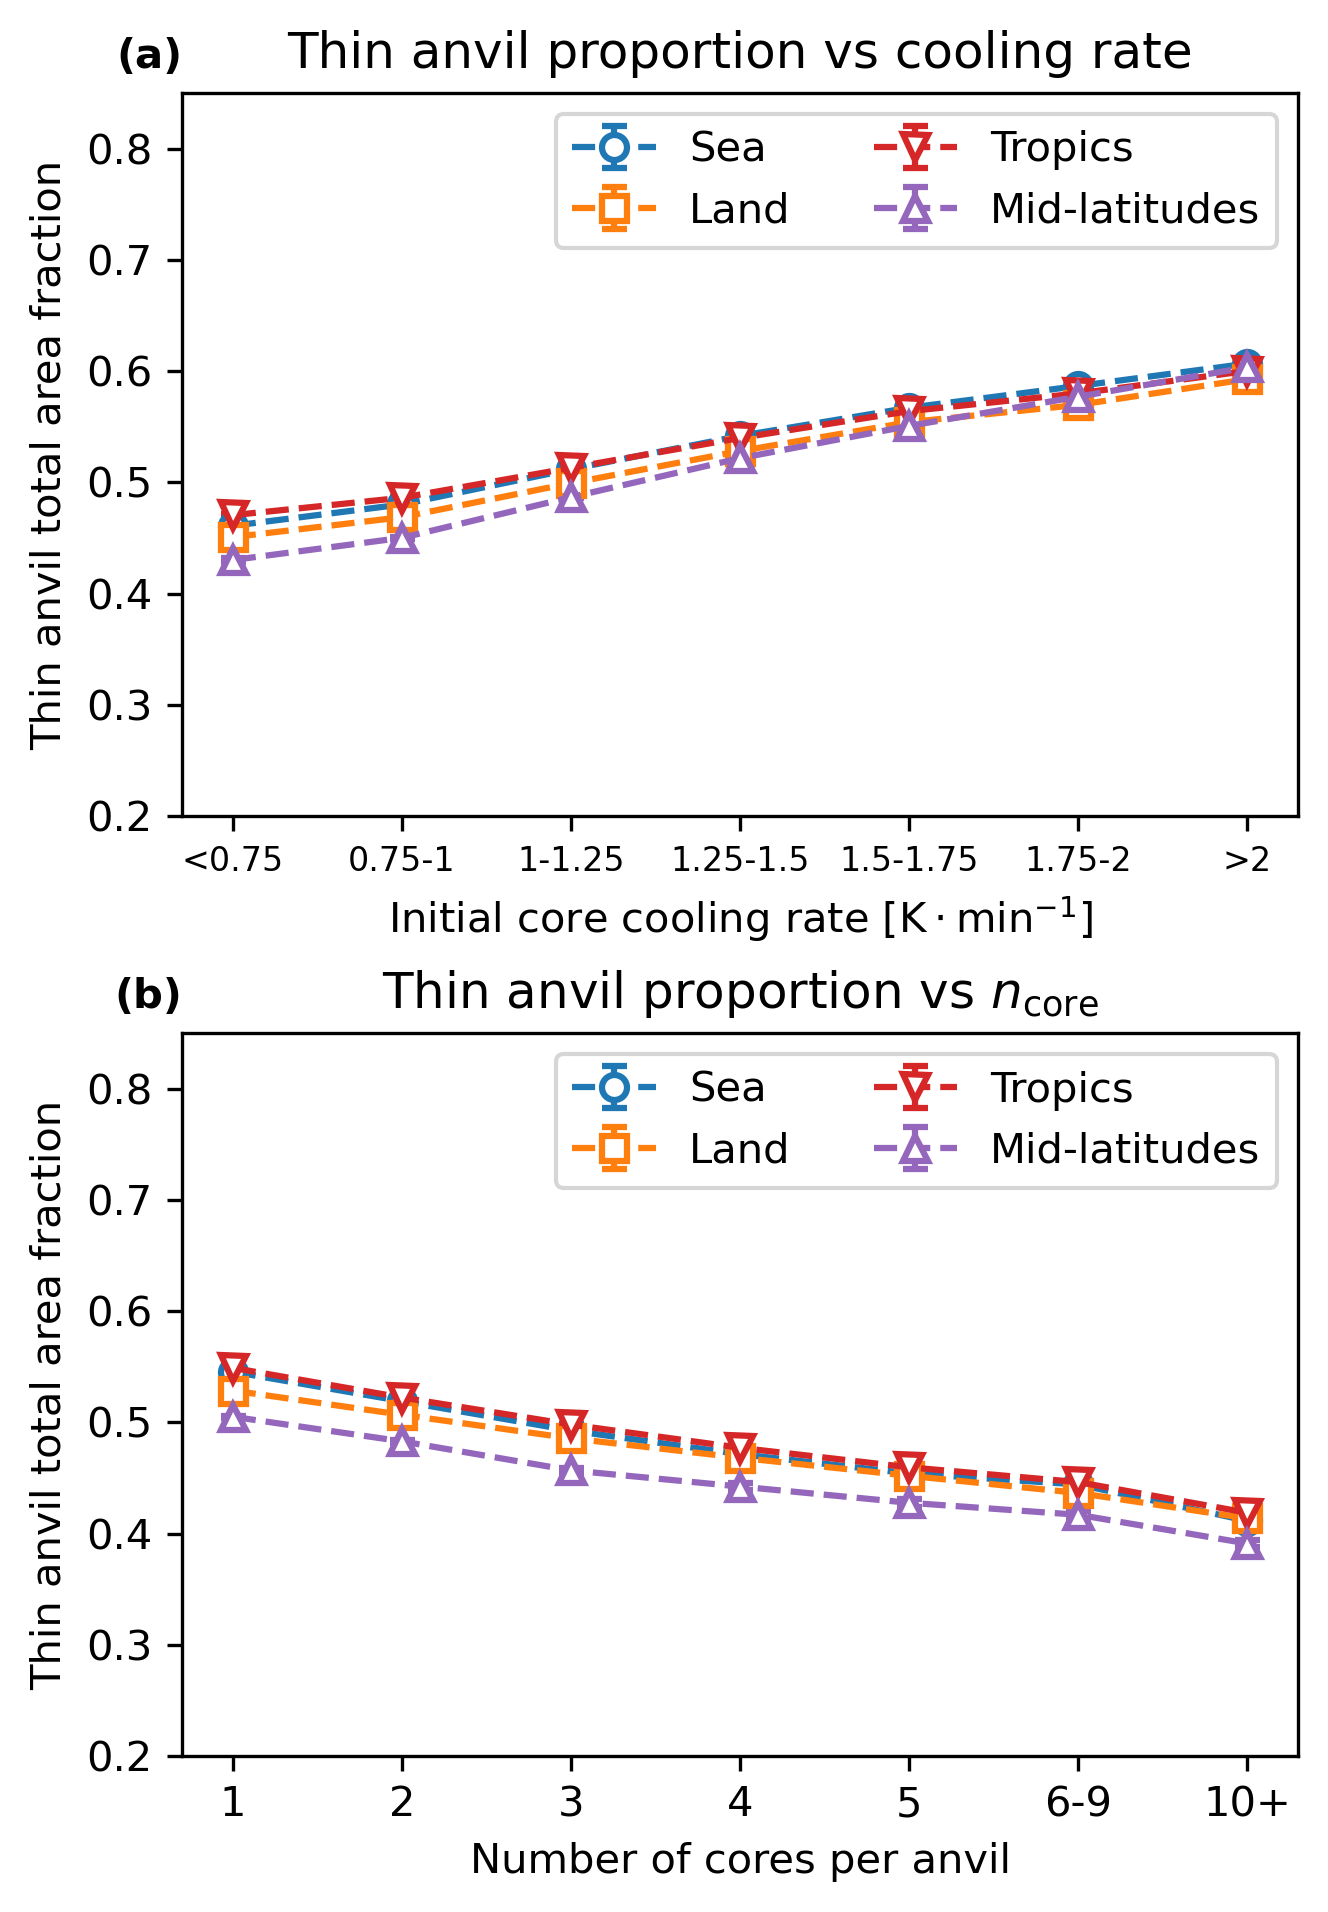

In [22]:
plt.figure(dpi=dpi, figsize=(4.8,7.2))

plt.subplot(211)

anvil_cooling_bins = [0,0.75,1,1.25,1.5,1.75,2,10]
anvil_cooling_labels = [f"{anvil_cooling_bins[i]}-{anvil_cooling_bins[i+1]}" if 0<i<(len(anvil_cooling_bins)-2) 
              else f"<{anvil_cooling_bins[i+1]}" if i == 0 else f">{anvil_cooling_bins[i]}"
              for i in range(len(ctt_bins)-1)]
bin_positions = np.arange(1, len(anvil_cooling_bins))

sea_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid & anvil_sea_mask], 
    anvil_area_prop[anvil_is_valid & anvil_sea_mask], 
    anvil_cooling_bins, locs=bin_positions, ylog=False, 
    color="C0", fmt="o--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

land_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid & ~anvil_sea_mask], 
    anvil_area_prop[anvil_is_valid & ~anvil_sea_mask], 
    anvil_cooling_bins, locs=bin_positions, ylog=False, 
    color="C1", fmt="s--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

tropic_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid & (anvil_start_lat<=30)], 
    anvil_area_prop[anvil_is_valid & (anvil_start_lat<=30)], 
    anvil_cooling_bins, locs=bin_positions, ylog=False, 
    color="C3", fmt="v--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

midlat_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid & (anvil_start_lat>30)], 
    anvil_area_prop[anvil_is_valid & (anvil_start_lat>30)], 
    anvil_cooling_bins, locs=bin_positions, ylog=False, 
    color="C4", fmt="^--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

plt.xticks(np.arange(1, len(anvil_cooling_bins)), anvil_cooling_labels, fontsize=8)
plt.xlabel("Initial core cooling rate [$\mathrm{K\cdot min^{-1}}$]")
plt.ylabel("Thin anvil total area fraction")
plt.title("Thin anvil proportion vs cooling rate")
plt.title("(a)", loc="left", ha="right", weight="bold", fontsize=10)
plt.legend([sea_line, land_line, tropic_line, midlat_line], ["Sea", "Land", "Tropics", "Mid-latitudes"], ncol=2)

plt.ylim([0.2,0.85])

plt.subplot(212)

bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = np.array([1, 2, 3, 4, 5, 6, 7])
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

sea_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid & anvil_sea_mask], 
    anvil_area_prop[anvil_is_valid & anvil_sea_mask], 
    bins, locs=bin_positions, ylog=False, 
    color="C0", fmt="o--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

land_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid & ~anvil_sea_mask], 
    anvil_area_prop[anvil_is_valid & ~anvil_sea_mask], 
    bins, locs=bin_positions, ylog=False, 
    color="C1", fmt="s--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

tropic_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid & (anvil_start_lat<=30)], 
    anvil_area_prop[anvil_is_valid & (anvil_start_lat<=30)], 
    bins, locs=bin_positions, ylog=False, 
    color="C3", fmt="v--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

midlat_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid & (anvil_start_lat>30)], 
    anvil_area_prop[anvil_is_valid & (anvil_start_lat>30)], 
    bins, locs=bin_positions, ylog=False, 
    color="C4", fmt="^--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

plt.xticks(np.arange(1, len(bins)), bin_labels)
plt.xlabel("Number of cores per anvil")
plt.ylabel("Thin anvil total area fraction")
plt.title("Thin anvil proportion vs $n_{\mathrm{core}}$")
plt.title("(b)", loc="left", ha="right", weight="bold", fontsize=10)
plt.legend([sea_line, land_line, tropic_line, midlat_line], ["Sea", "Land", "Tropics", "Mid-latitudes"], ncol=2)
plt.ylim([0.2,0.85])

plt.subplots_adjust(hspace=0.3)

figure_list.append(plt.gcf())

## Plot change in anvil properties with cooling rate

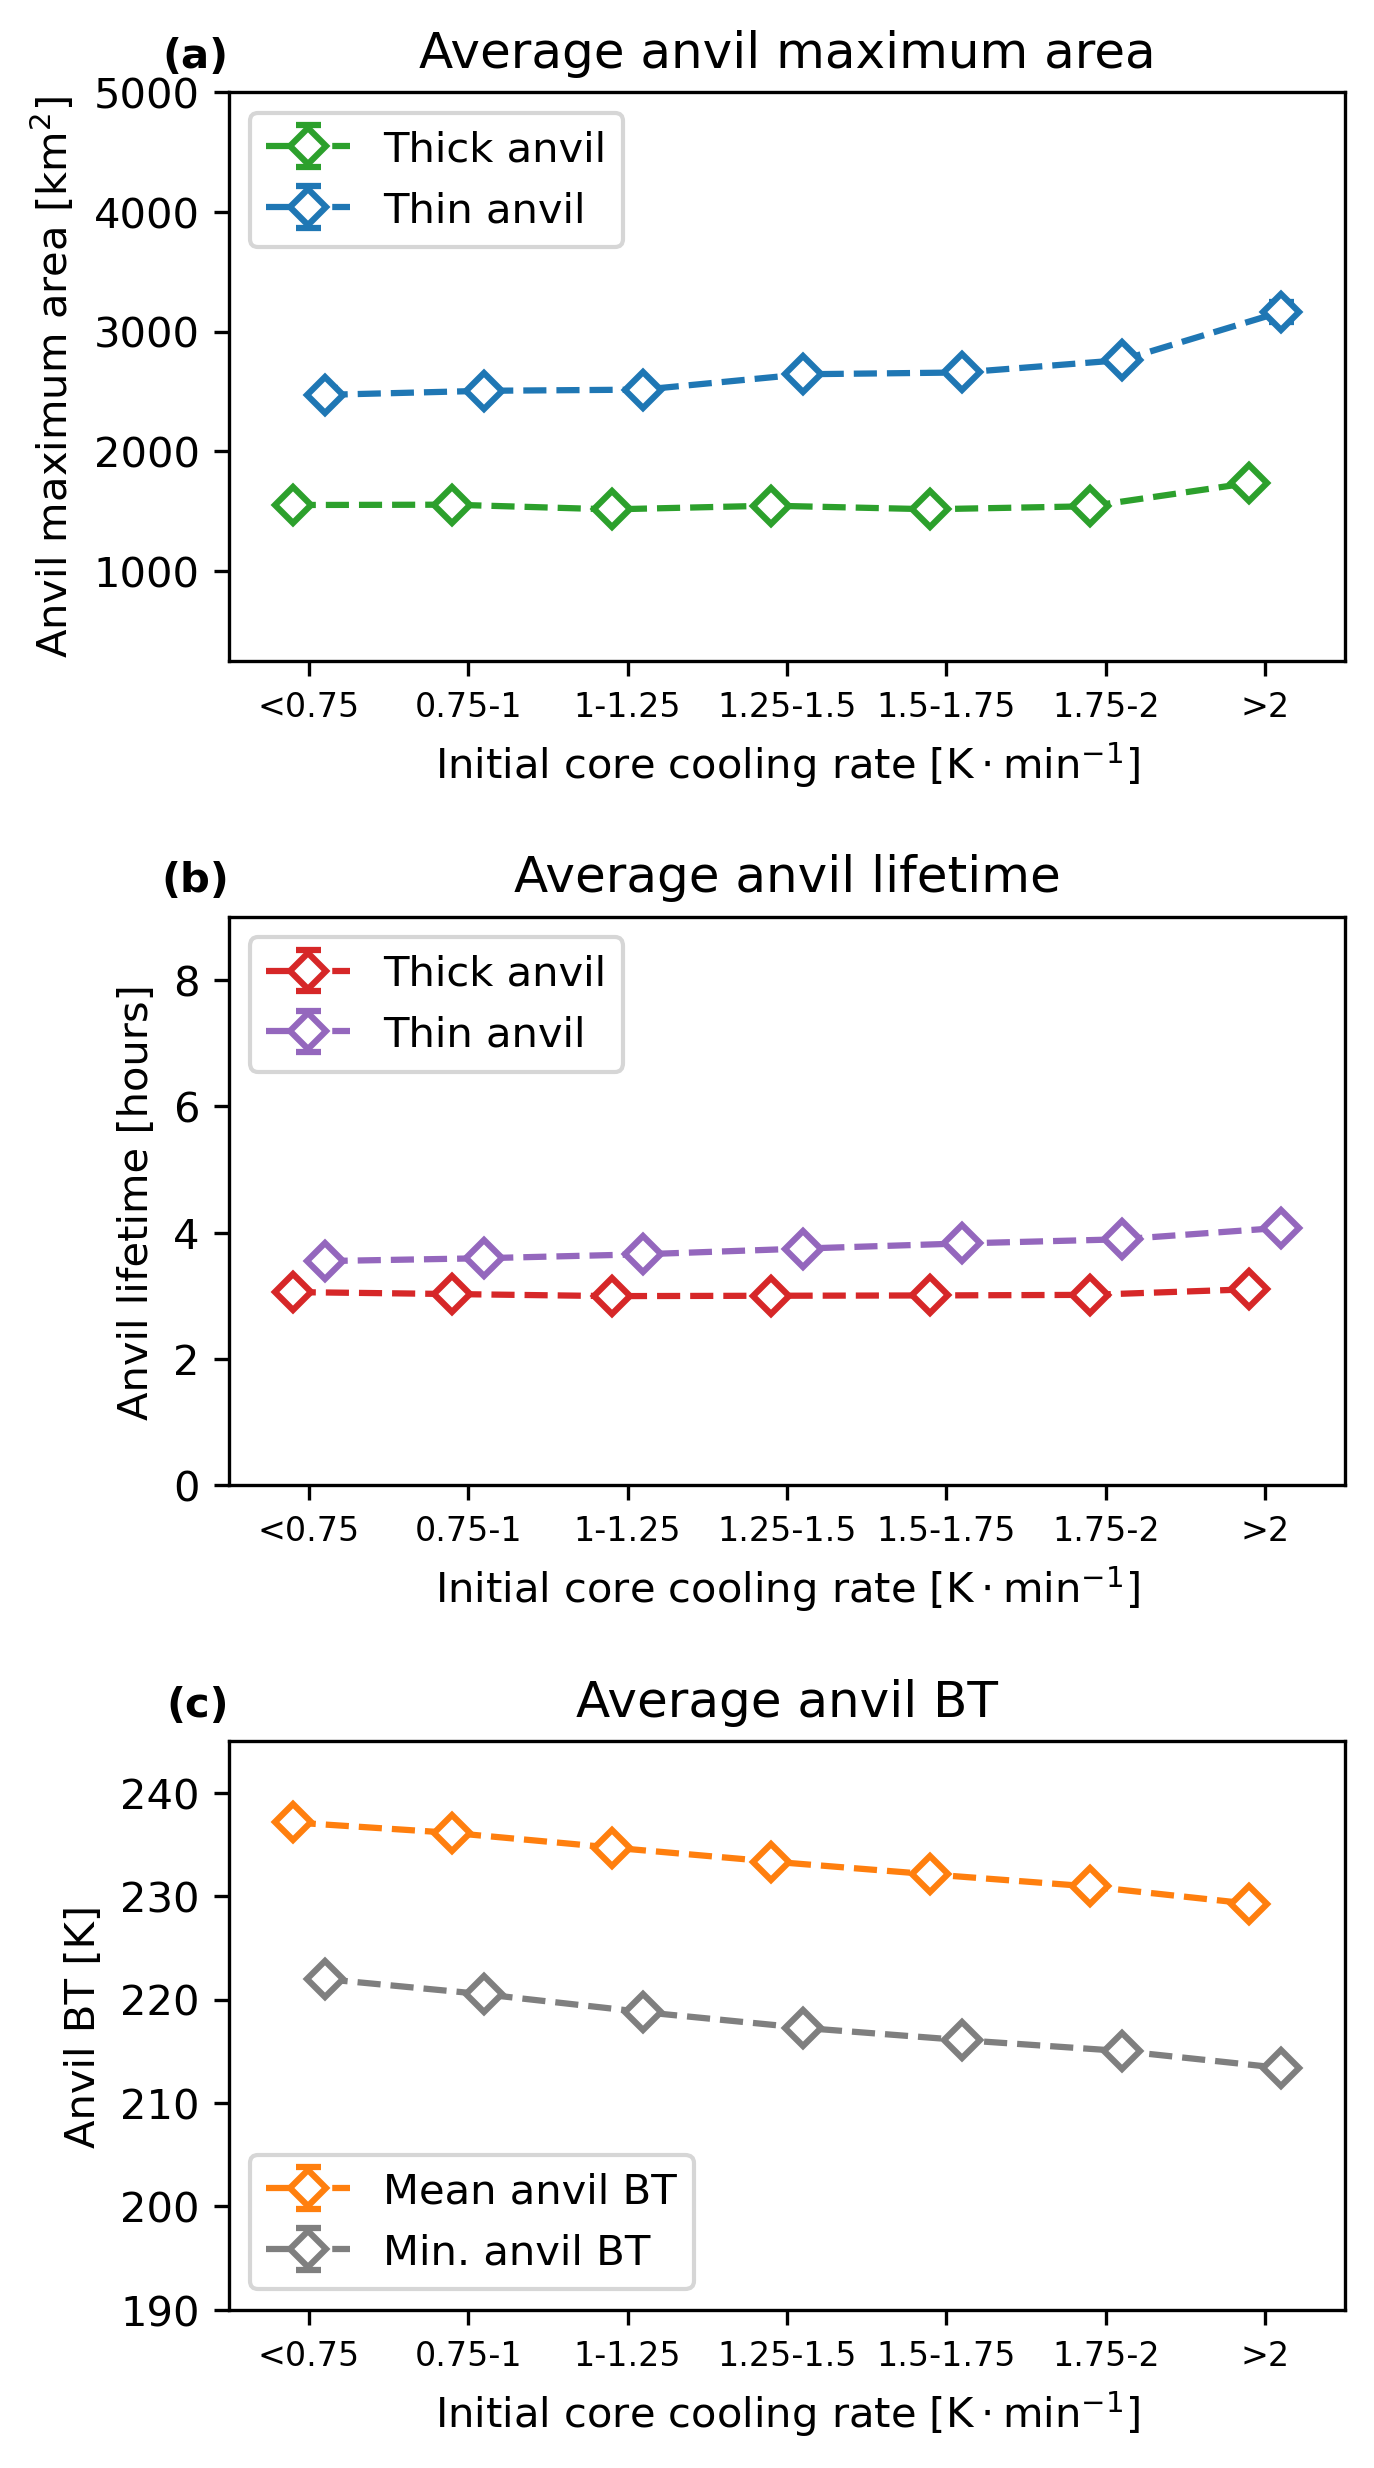

In [23]:
fig = plt.figure(dpi=dpi, figsize=(4.8,9.6))

bins = anvil_cooling_bins
bin_positions = np.arange(1, len(bins))
bin_labels = anvil_cooling_labels

ax1 = plt.subplot(311)

thick_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid], anvil_max_area[anvil_is_valid], bins, locs=bin_positions-0.1, ylog=False, 
    color="C2", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

thin_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid], thin_anvil_max_area[anvil_is_valid], bins, locs=bin_positions+0.1, ylog=False, 
    color="C0", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

plt.ylim([2.5e2, 5e3])
plt.legend([thick_line, thin_line], ["Thick anvil", "Thin anvil"], loc="upper left", fontsize=10)

plt.xlim([0.5,7.5])
plt.xticks(bin_positions, bin_labels, fontsize=8)
plt.xlabel("Initial core cooling rate [$\mathrm{K\cdot min^{-1}}$]", fontsize=10)
plt.ylabel("Anvil maximum area [$\mathrm{km^2}$]", fontsize=10)
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)
ax1.set_title("Average anvil maximum area", fontsize=12)
# ax1.tick_params(axis='both', which='major', labelsize=8)

ax2 = plt.subplot(312)

thick_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid], anvil_lifetime[anvil_is_valid], bins, locs=bin_positions-0.1, #ylog=True, 
    color="C3", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

thin_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid], thin_anvil_lifetime[anvil_is_valid], bins, locs=bin_positions+0.1, #ylog=True, 
    color="C4", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

plt.ylim([0,9])
plt.legend([thick_line, thin_line], ["Thick anvil", "Thin anvil"], loc="upper left", fontsize=10)

plt.xlim([0.5,7.5])
plt.xticks(bin_positions, bin_labels, fontsize=8)
plt.xlabel("Initial core cooling rate [$\mathrm{K\cdot min^{-1}}$]", fontsize=10)
plt.ylabel("Anvil lifetime [hours]", fontsize=10)
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)
ax2.set_title("Average anvil lifetime", fontsize=12)
# ax2.tick_params(axis='both', which='major', labelsize=8)

ax4 = plt.subplot(313)

thick_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid], anvil_ctt_mean[anvil_is_valid], bins, locs=bin_positions-0.1, #ylog=True, 
    color="C1", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

thin_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid], anvil_ctt_min[anvil_is_valid], bins, locs=bin_positions+0.1, #ylog=True, 
    color="C7", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

plt.ylim([190, 245])
plt.legend([thick_line, thin_line], ["Mean anvil BT", "Min. anvil BT"], loc="lower left", fontsize=10)

plt.xlim([0.5, 7.5])
plt.xticks(bin_positions, bin_labels, fontsize=8)
plt.xlabel("Initial core cooling rate [$\mathrm{K\cdot min^{-1}}$]", fontsize=10)
plt.ylabel("Anvil BT [K]", fontsize=10)
ax4.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=10)
ax4.set_title("Average anvil BT", fontsize=12)
# ax4.tick_params(axis='both', which='major', labelsize=8)

plt.subplots_adjust(hspace=0.45)

figure_list.append(plt.gcf())

## Plot change in anvil properties with number of cores

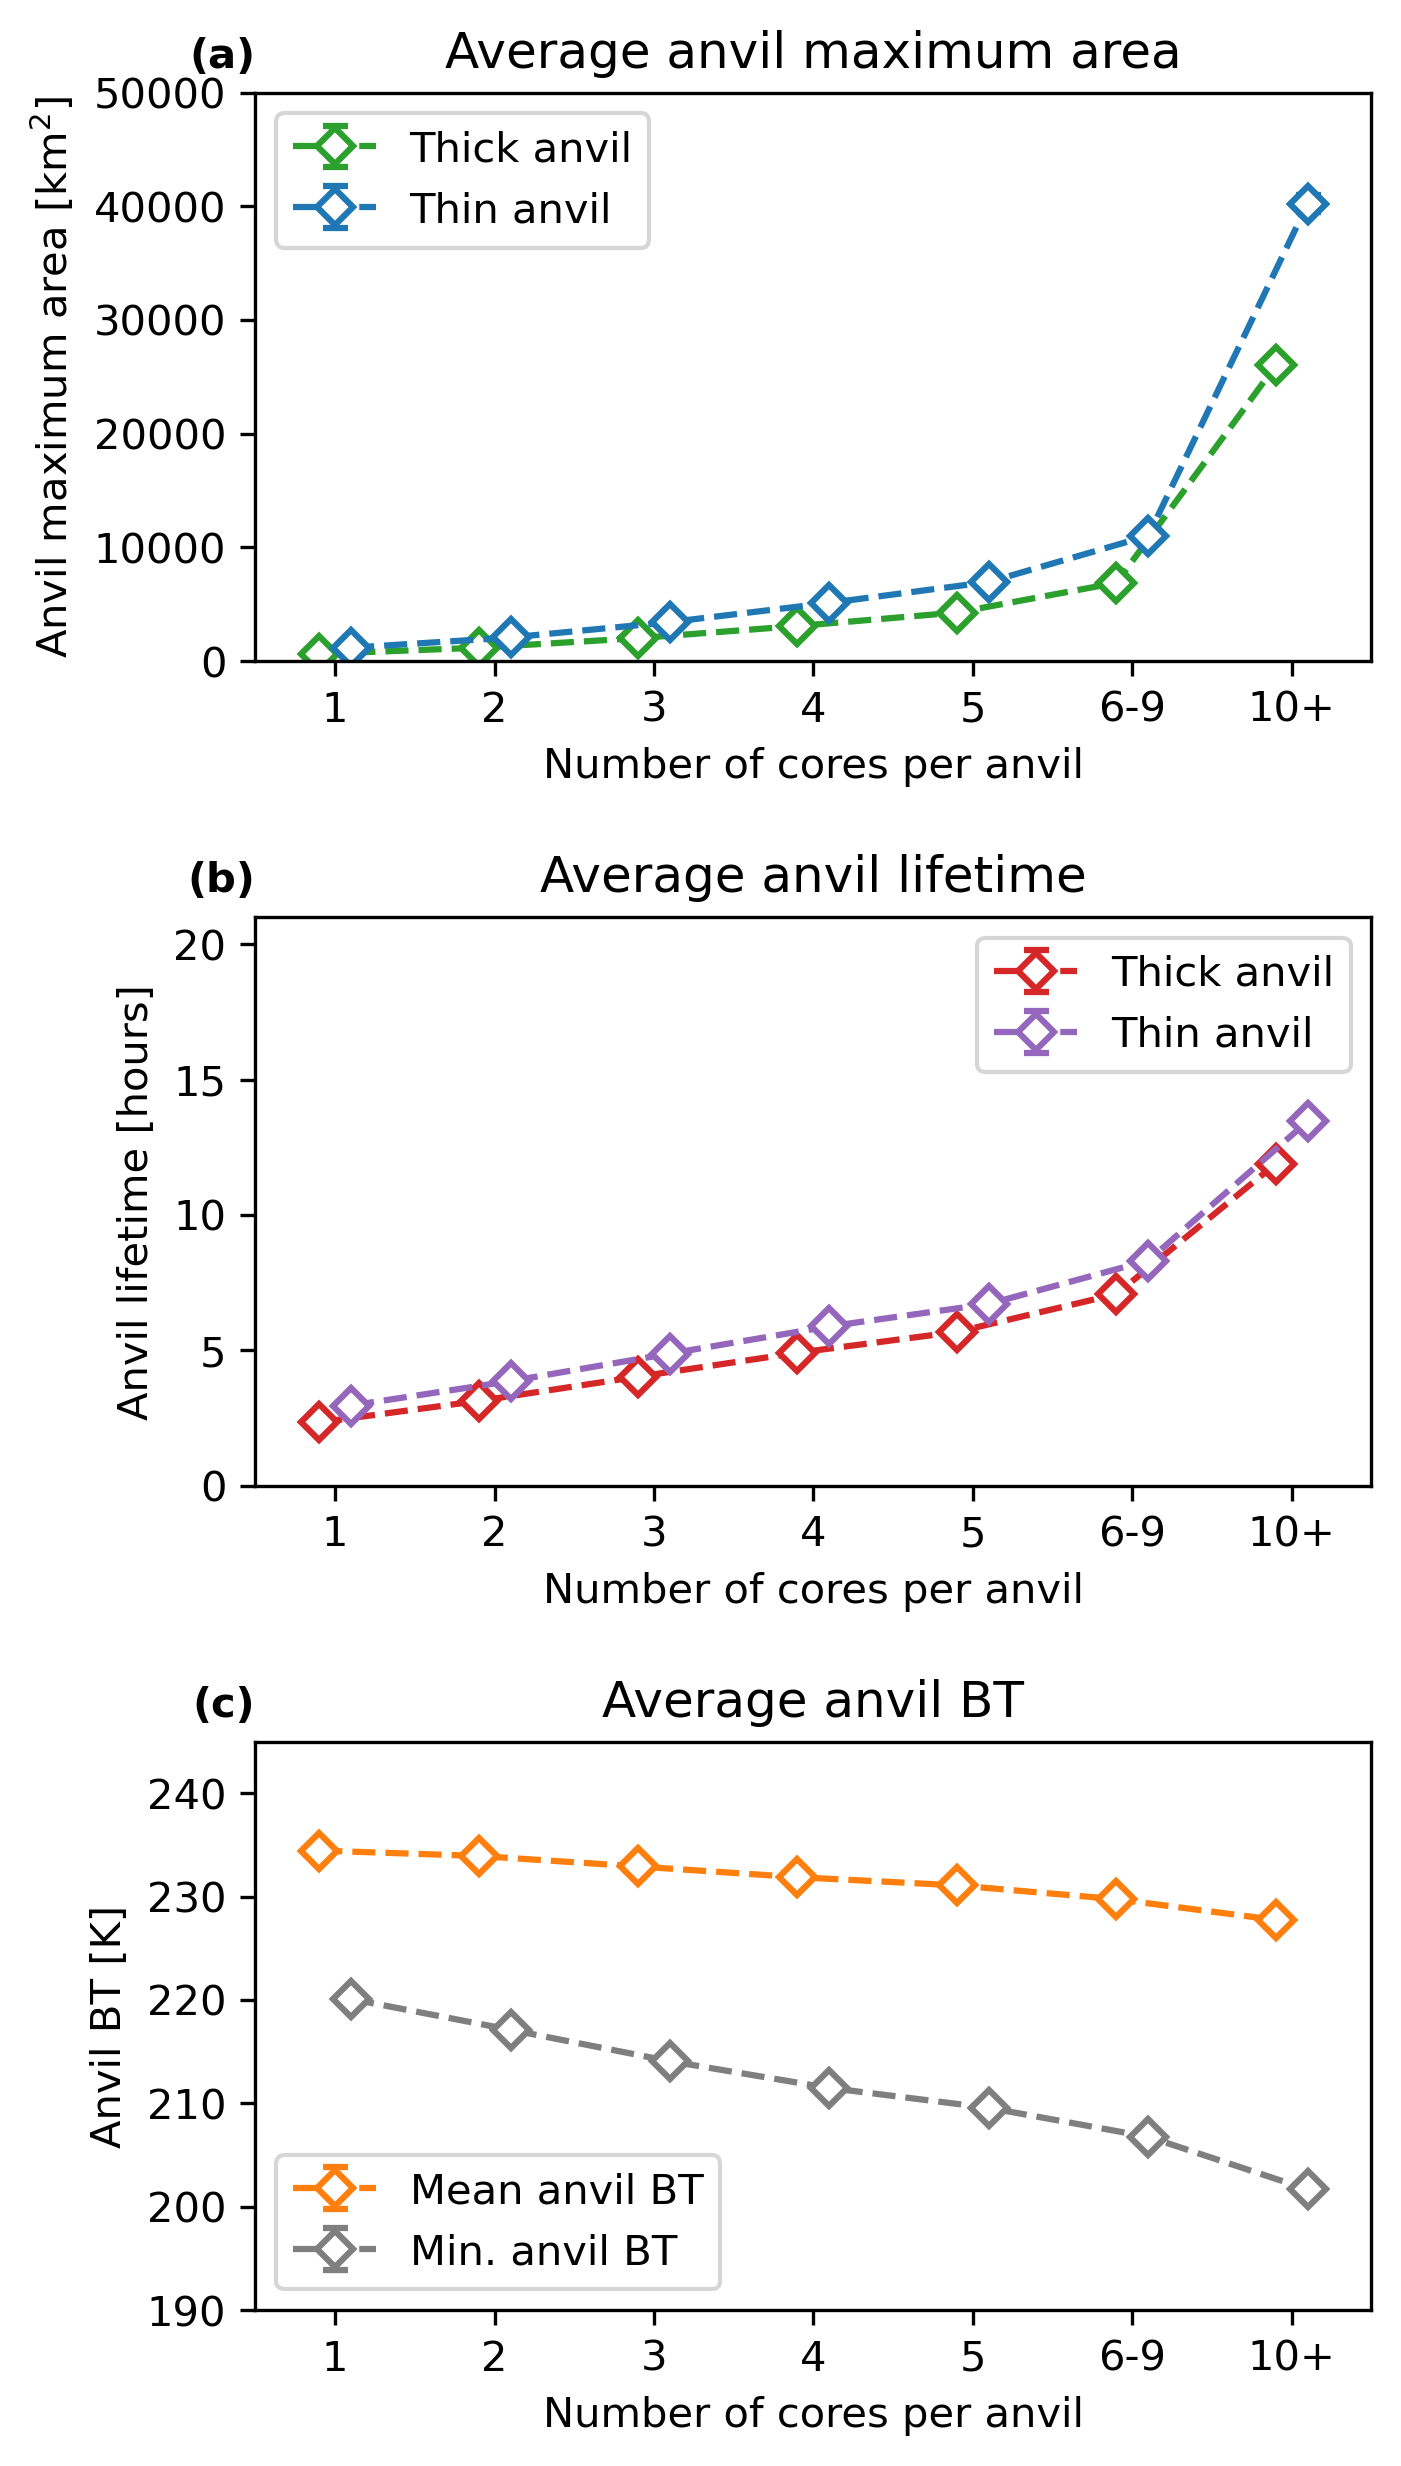

In [24]:
fig = plt.figure(dpi=dpi, figsize=(4.8,9.6))

bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = np.array([1, 2, 3, 4, 5, 6, 7])
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

ax1 = plt.subplot(311)

thick_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid], anvil_max_area[anvil_is_valid], bins, locs=bin_positions-0.1, ylog=False, 
    color="C2", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

thin_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid], thin_anvil_max_area[anvil_is_valid], bins, locs=bin_positions+0.1, ylog=False, 
    color="C0", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

plt.ylim([0, 5e4])
plt.legend([thick_line, thin_line], ["Thick anvil", "Thin anvil"], fontsize=10)

plt.xlim([0.5,7.5])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=10)
plt.ylabel("Anvil maximum area [$\mathrm{km^2}$]", fontsize=10)
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)
ax1.set_title("Average anvil maximum area", fontsize=12)
# ax1.tick_params(axis='both', which='major', labelsize=8)

ax2 = plt.subplot(312)

thick_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid], anvil_lifetime[anvil_is_valid], bins, locs=bin_positions-0.1, #ylog=True, 
    color="C3", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

thin_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid], thin_anvil_lifetime[anvil_is_valid], bins, locs=bin_positions+0.1, #ylog=True, 
    color="C4", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

plt.ylim([0,21])
plt.legend([thick_line, thin_line], ["Thick anvil", "Thin anvil"], fontsize=10)

plt.xlim([0.5,7.5])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=10)
plt.ylabel("Anvil lifetime [hours]", fontsize=10)
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)
ax2.set_title("Average anvil lifetime", fontsize=12)
# ax2.tick_params(axis='both', which='major', labelsize=8)

ax4 = plt.subplot(313)

thick_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid], anvil_ctt_mean[anvil_is_valid], bins, locs=bin_positions-0.1, #ylog=True, 
    color="C1", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

thin_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid], anvil_ctt_min[anvil_is_valid], bins, locs=bin_positions+0.1, #ylog=True, 
    color="C7", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

plt.ylim([190, 245])
plt.legend([thick_line, thin_line], ["Mean anvil BT", "Min. anvil BT"], fontsize=10)

plt.xlim([0.5, 7.5])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=10)
plt.ylabel("Anvil BT [K]", fontsize=10)
ax4.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=10)
ax4.set_title("Average anvil BT", fontsize=12)
# ax4.tick_params(axis='both', which='major', labelsize=8)

plt.subplots_adjust(hspace=0.45)

figure_list.append(plt.gcf())

In [25]:
anvil_max_area_prop = 1 - (anvil_max_area / thin_anvil_max_area)
anvil_lifetime_prop = 1 - (thick_anvil_lifetime / thin_anvil_lifetime)

## Contribution of maximum area and lifetime differences to thin anvil fraction

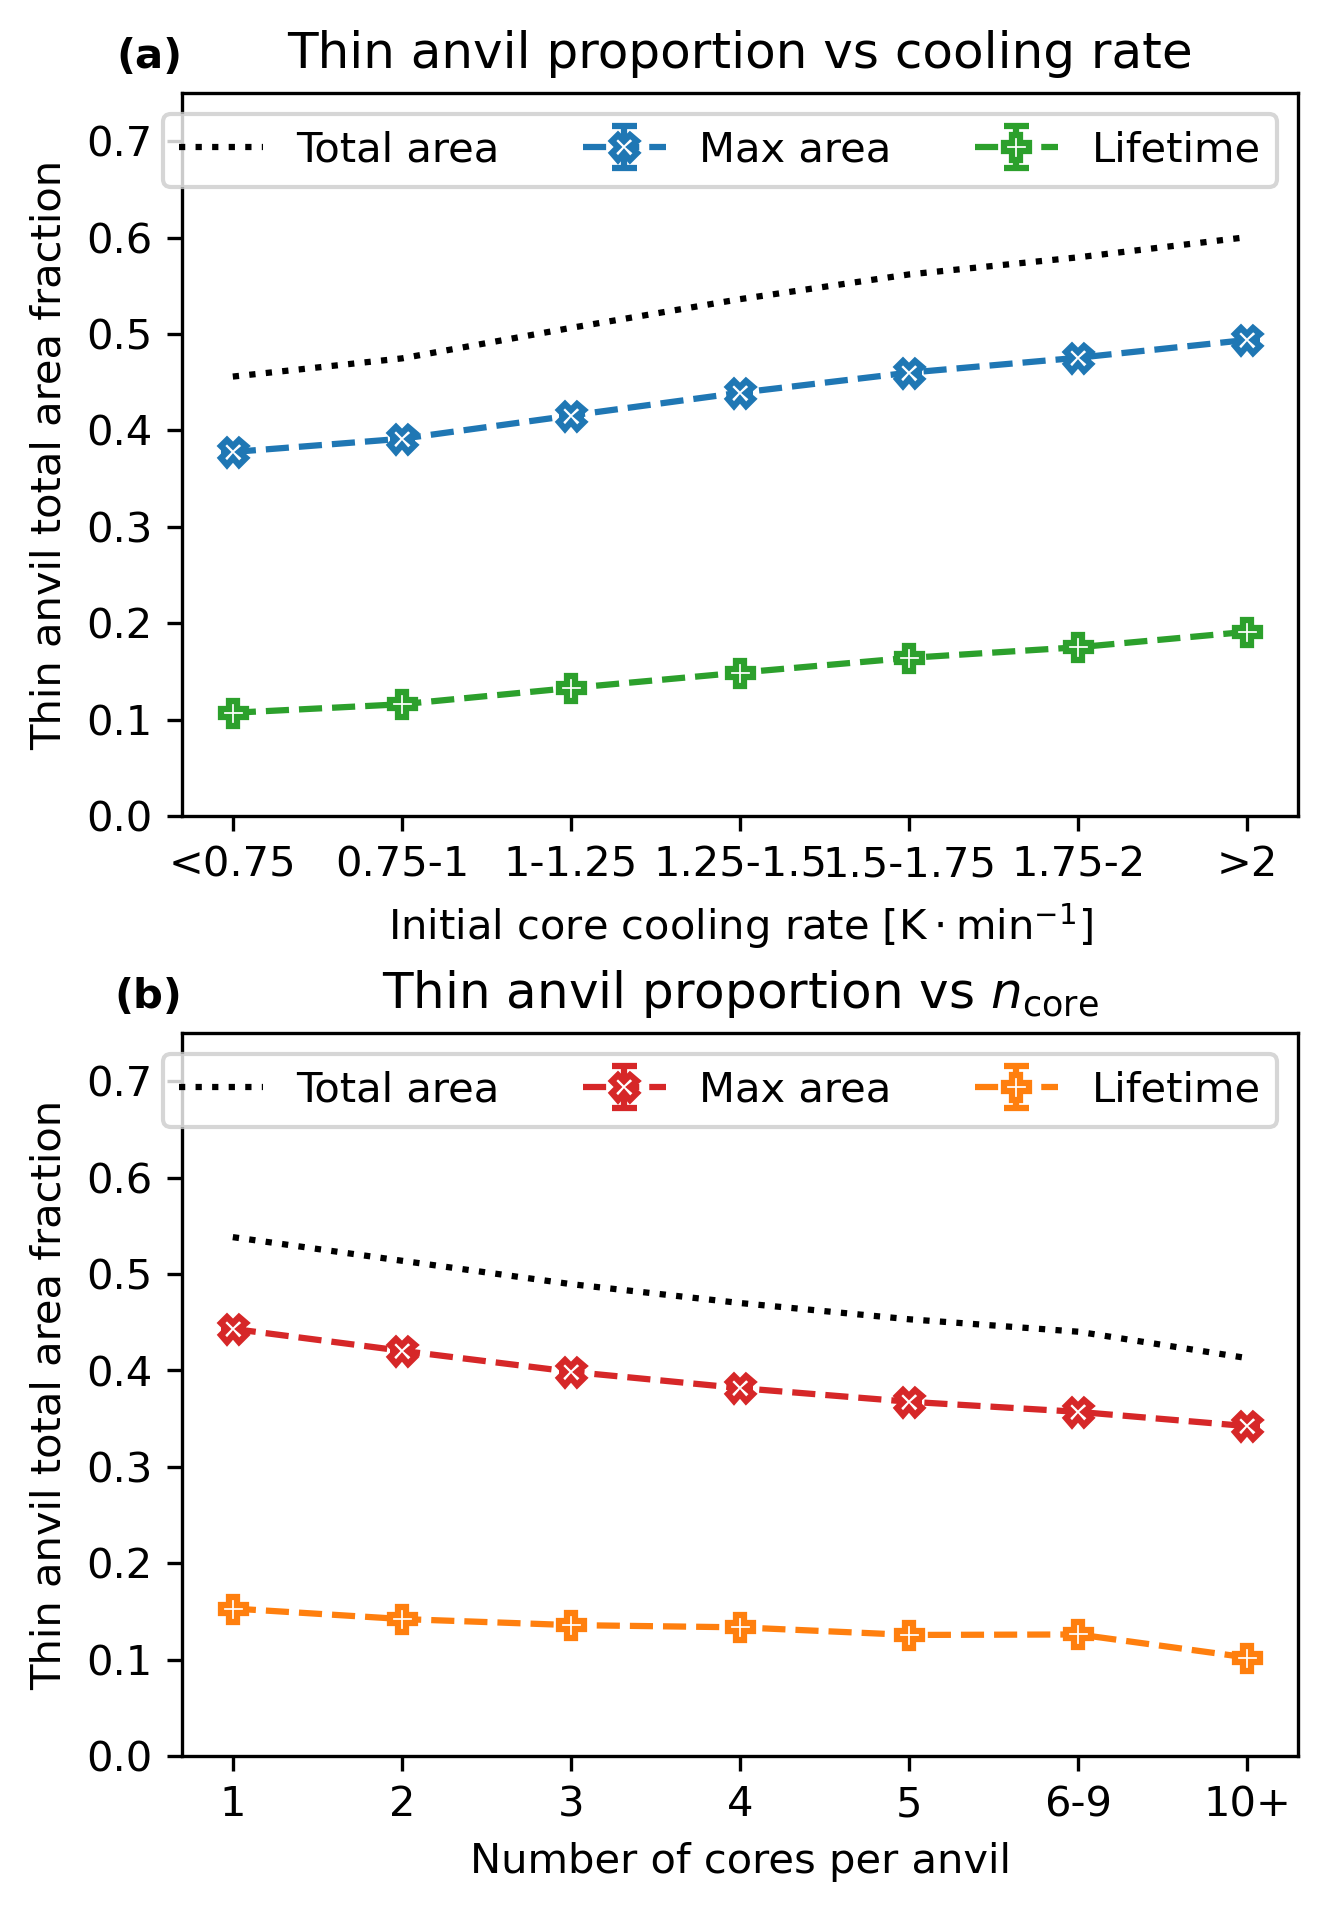

In [26]:
plt.figure(dpi=dpi, figsize=(4.8,7.2))

plt.subplot(211)

anvil_cooling_bins = [0,0.75,1,1.25,1.5,1.75,2,10]
anvil_cooling_labels = [f"{anvil_cooling_bins[i]}-{anvil_cooling_bins[i+1]}" if 0<i<(len(anvil_cooling_bins)-2) 
              else f"<{anvil_cooling_bins[i+1]}" if i == 0 else f">{anvil_cooling_bins[i]}"
              for i in range(len(ctt_bins)-1)]
bin_positions = np.arange(1, len(anvil_cooling_bins))

# all_line, _ = binned_plot(
#     initial_core_cooling_rate[anvil_is_valid], 
#     anvil_area_prop[anvil_is_valid], 
#     anvil_cooling_bins, locs=bin_positions-0.1, ylog=False, 
#     color="k", fmt="D--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
# )

all_line = plt.plot(
    bin_positions, 
    binned_statistic(
        initial_core_cooling_rate[anvil_is_valid], anvil_area_prop[anvil_is_valid], 
        bins=anvil_cooling_bins, statistic=np.mean)[0],
    "k:"
)[0]

max_line = binned_plot(
    initial_core_cooling_rate[anvil_is_valid], 
    anvil_max_area_prop[anvil_is_valid], 
    anvil_cooling_bins, locs=bin_positions, ylog=False, 
    color="C0", fmt="X--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

# lifetime_line, _ = binned_plot(
#     initial_core_cooling_rate[anvil_is_valid], 
#     anvil_lifetime_prop[anvil_is_valid], 
#     anvil_cooling_bins, locs=bin_positions, ylog=False, 
#     color="C2", fmt="P--", mfc="white", ms=8, capsize=3, linewidth=1.5, mew=1.5,
# )

binned_data = 1 - (
    binned_statistic(
        initial_core_cooling_rate[anvil_is_valid], thick_anvil_lifetime[anvil_is_valid], bins=anvil_cooling_bins, statistic=np.mean
    )[0]
    / binned_statistic(
        initial_core_cooling_rate[anvil_is_valid], thin_anvil_lifetime[anvil_is_valid], bins=anvil_cooling_bins, statistic=np.mean
    )[0]
)
    
std = binned_statistic(
    initial_core_cooling_rate[anvil_is_valid], anvil_lifetime_prop[anvil_is_valid], bins=anvil_cooling_bins, statistic=corrected_std
)[0]
counts = np.histogram(initial_core_cooling_rate[anvil_is_valid], bins=anvil_cooling_bins)[0]
errors = std / counts**0.5

lifetime_line = plt.errorbar(
    bin_positions, binned_data, errors, color="C2", fmt="P--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5
)
# fill = plt.fill_between(
#     bin_positions, binned_data+errors, binned_data-errors,
#     alpha=0.5, color="C2", edgecolor=None
# )

plt.xticks(np.arange(1, len(anvil_cooling_bins)), anvil_cooling_labels)
plt.xlabel("Initial core cooling rate [$\mathrm{K \cdot min^{-1}}$]")
plt.ylabel("Thin anvil total area fraction")
plt.title("Thin anvil proportion vs cooling rate")
plt.title("(a)", loc="left", ha="right", weight="bold", fontsize=10)
plt.legend([all_line, max_line, lifetime_line], ["Total area", "Max area", "Lifetime"], ncol=3)

plt.ylim([0.,0.75])

plt.subplot(212)

anvil_cooling_bins = [0,0.75,1,1.25,1.5,1.75,2,10]
anvil_cooling_labels = [f"{anvil_cooling_bins[i]}-{anvil_cooling_bins[i+1]}" if 0<i<(len(anvil_cooling_bins)-2) 
              else f"<{anvil_cooling_bins[i+1]}" if i == 0 else f">{anvil_cooling_bins[i]}"
              for i in range(len(ctt_bins)-1)]
bin_positions = np.arange(1, len(anvil_cooling_bins))

bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = np.array([1, 2, 3, 4, 5, 6, 7])
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

all_line = plt.plot(
    bin_positions, 
    binned_statistic(
        anvil_number_of_cores[anvil_is_valid], anvil_area_prop[anvil_is_valid], 
        bins=bins, statistic=np.mean)[0],
    "k:"
)[0]

max_line = binned_plot(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_max_area_prop[anvil_is_valid], 
    bins, locs=bin_positions, ylog=False, 
    color="C3", fmt="X--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5,
)

# lifetime_line, _ = binned_plot(
#     anvil_number_of_cores[anvil_is_valid], 
#     anvil_lifetime_prop[anvil_is_valid], 
#     bins, locs=bin_positions, ylog=False, 
#     color="C1", fmt="P--", mfc="white", ms=8, capsize=3, linewidth=1.5, mew=1.5,
# )

binned_data = 1 - (
    binned_statistic(
        anvil_number_of_cores[anvil_is_valid], thick_anvil_lifetime[anvil_is_valid], bins=bins, statistic=np.mean
    )[0]
    / binned_statistic(
        anvil_number_of_cores[anvil_is_valid], thin_anvil_lifetime[anvil_is_valid], bins=bins, statistic=np.mean
    )[0]
)
    
std = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], anvil_lifetime_prop[anvil_is_valid], bins=bins, statistic=corrected_std
)[0]
counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)[0]
errors = std / counts**0.5

lifetime_line = plt.errorbar(
    bin_positions, binned_data, errors, color="C1", fmt="P--", mfc="white", ms=6, capsize=3, linewidth=1.5, mew=1.5
)
# fill = plt.fill_between(
#     bin_positions, binned_data+errors, binned_data-errors,
#     alpha=0.5, color="C1", edgecolor=None
# )

plt.xticks(np.arange(1, len(bins)), bin_labels)
plt.xlabel("Number of cores per anvil")
plt.ylabel("Thin anvil total area fraction")
plt.title("Thin anvil proportion vs $n_{\mathrm{core}}$")
plt.title("(b)", loc="left", ha="right", weight="bold", fontsize=10)
plt.legend([all_line, max_line, lifetime_line], ["Total area", "Max area", "Lifetime"], ncol=3)
plt.ylim([0.,0.75])

plt.subplots_adjust(hspace=0.3)

figure_list.append(plt.gcf())

## Lifecycle stages by cooling rate

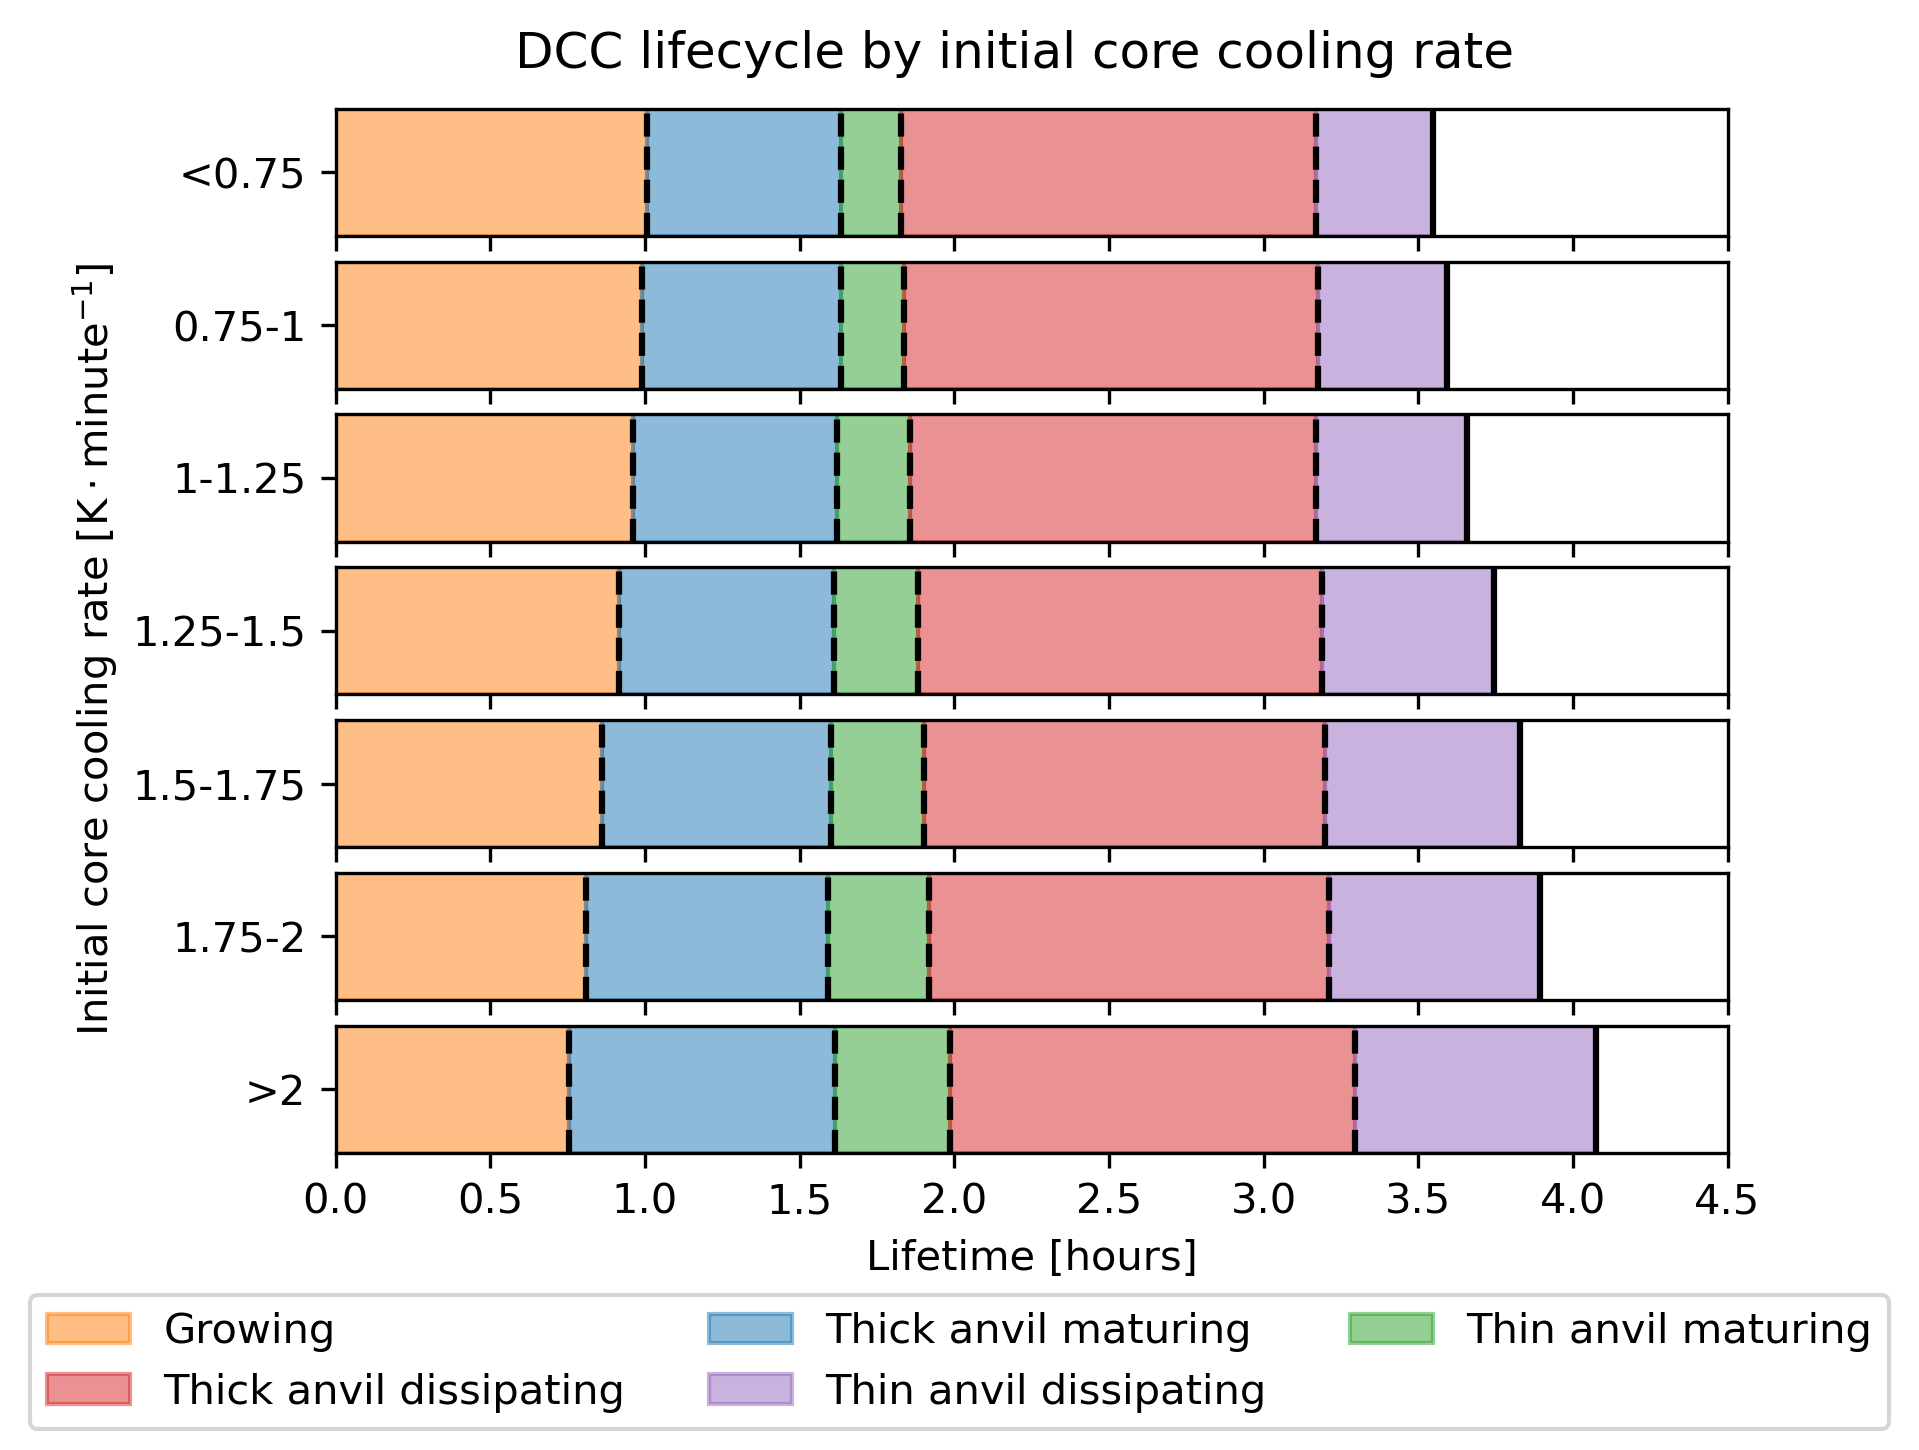

In [27]:
fig, axes = plt.subplots(7, 1, sharex=True, dpi=dpi)

for i in range(1,8):
    wh = np.logical_and(
        initial_core_cooling_rate >= anvil_cooling_bins[i-1], 
        initial_core_cooling_rate < anvil_cooling_bins[i]
    )
        
    wh = np.logical_and(wh, anvil_is_valid)
    
    ylabel = [anvil_cooling_labels[i-1]]
        
    ax = axes[i-1]
    
    min_bt_t = np.nanmean(anvil_time_to_min_BT[wh])
    max_thick_area_t = np.nanmean(anvil_time_to_max_thick_area[wh])
    max_thin_area_t = np.nanmean(anvil_time_to_max_thin_area[wh])
    thick_lifetime_t = np.nanmean(thick_anvil_lifetime[wh])
    thin_lifetime_t = np.nanmean(thin_anvil_lifetime[wh])
    
    f1 = ax.fill_between([0,min_bt_t],[0,0],[1,1],color="C1",alpha=0.5)
    ax.axvline(x=min_bt_t, color='k', linestyle="--", linewidth=1.5)
    
    f2 = ax.fill_between([min_bt_t, max_thick_area_t],[0,0],[1,1],
                    color="C0",alpha=0.5)
    ax.axvline(x=max_thick_area_t, color='k', linestyle="--", linewidth=1.5)
    
    f3 = ax.fill_between([max_thick_area_t, max_thin_area_t],[0,0],[1,1],
                    color="C2",alpha=0.5)
    ax.axvline(x=max_thin_area_t, color='k', linestyle="--", linewidth=1.5)
    
    f4 = ax.fill_between([max_thin_area_t, thick_lifetime_t],[0,0],[1,1],
                    color="C3",alpha=0.5)
    ax.axvline(x=thick_lifetime_t, color='k', linestyle="--", linewidth=1.5)
    
    f5 = ax.fill_between([thick_lifetime_t, thin_lifetime_t],[0,0],[1,1],
                    color="C4",alpha=0.5)
    ax.axvline(x=thin_lifetime_t, color='k', linestyle="-", linewidth=1.5)
    
    ax.set_xlim([0,4.5])
    ax.set_yticks([0.5], ylabel)
    ax.set_ylim([0,1])

plt.xlabel("Lifetime [hours]")

plt.suptitle("       DCC lifecycle by initial core cooling rate")

fig.legend(
    [f1,f4,f2,f5,f3], 
    ["Growing", "Thick anvil dissipating", "Thick anvil maturing", "Thin anvil dissipating", "Thin anvil maturing"],
    loc="lower center", ncol=3
)

plt.subplots_adjust(left=0.175, top=0.925,  bottom=0.2)

fig.text(0.05, 0.55, "Initial core cooling rate [$\mathrm{K \cdot minute^{-1}}$]", rotation="vertical", ha="center", va="center")

figure_list.append(plt.gcf())

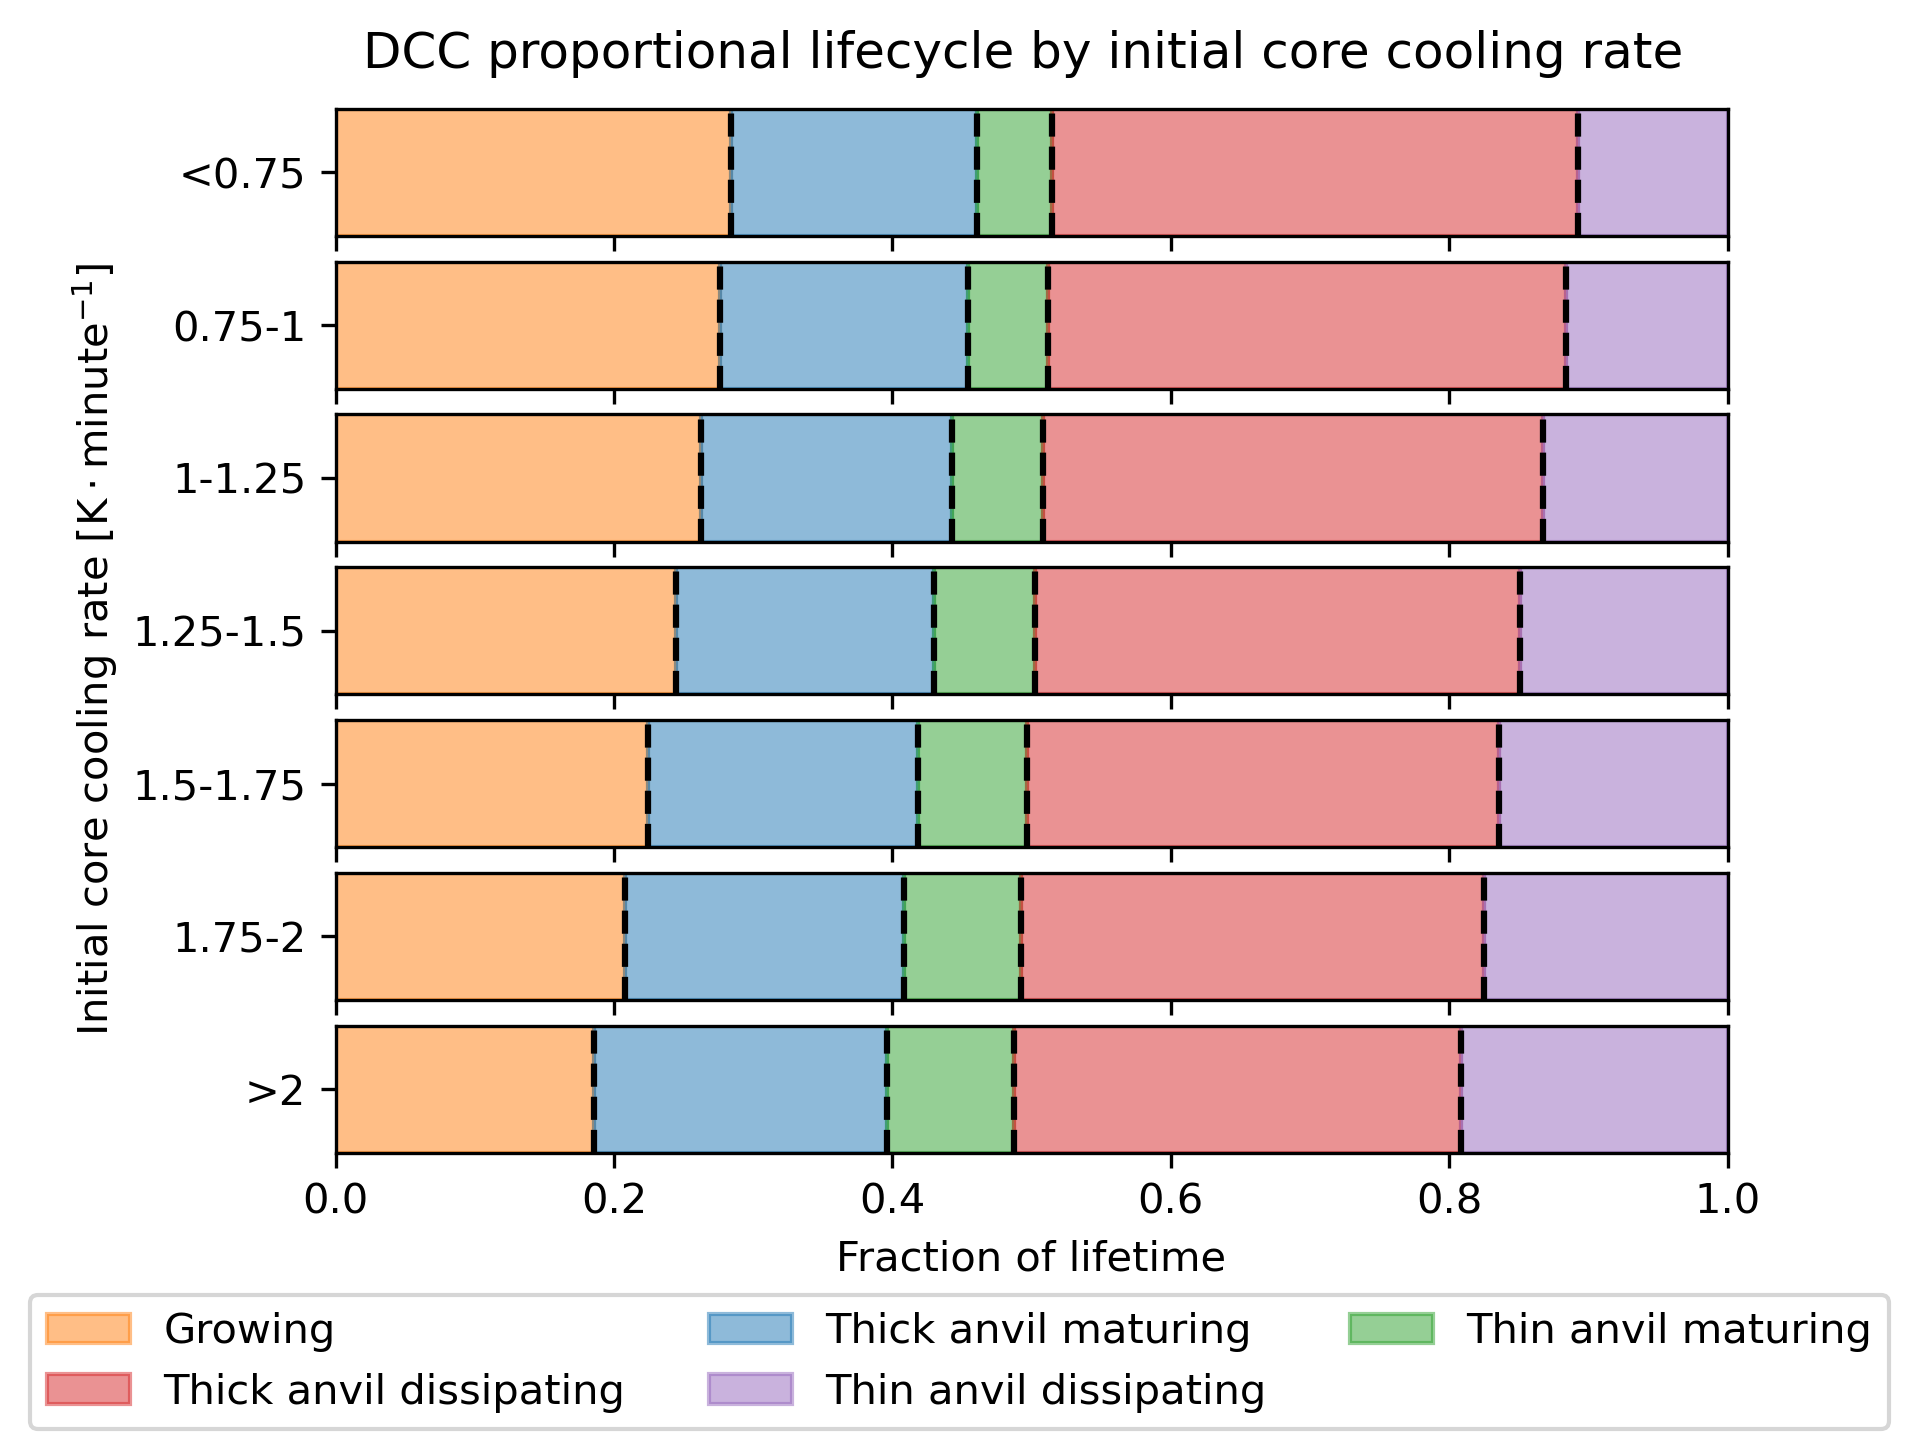

In [28]:
fig, axes = plt.subplots(7, 1, sharex=True, dpi=dpi)

for i in range(1,8):
    wh = np.logical_and(
        initial_core_cooling_rate >= anvil_cooling_bins[i-1], 
        initial_core_cooling_rate < anvil_cooling_bins[i]
    )
        
    wh = np.logical_and(wh, anvil_is_valid)
    
    ylabel = [anvil_cooling_labels[i-1]]
        
    ax = axes[i-1]
    
    min_bt_t = np.nanmean(anvil_time_to_min_BT[wh])
    max_thick_area_t = np.nanmean(anvil_time_to_max_thick_area[wh])
    max_thin_area_t = np.nanmean(anvil_time_to_max_thin_area[wh])
    thick_lifetime_t = np.nanmean(thick_anvil_lifetime[wh])
    thin_lifetime_t = np.nanmean(thin_anvil_lifetime[wh])
    
    f1 = ax.fill_between([0,min_bt_t/thin_lifetime_t],[0,0],[1,1],color="C1",alpha=0.5)
    ax.axvline(x=min_bt_t/thin_lifetime_t, color='k', linestyle="--", linewidth=1.5)
    
    f2 = ax.fill_between([min_bt_t/thin_lifetime_t, max_thick_area_t/thin_lifetime_t],[0,0],[1,1],
                    color="C0",alpha=0.5)
    ax.axvline(x=max_thick_area_t/thin_lifetime_t, color='k', linestyle="--", linewidth=1.5)
    
    f3 = ax.fill_between([max_thick_area_t/thin_lifetime_t, max_thin_area_t/thin_lifetime_t],[0,0],[1,1],
                    color="C2",alpha=0.5)
    ax.axvline(x=max_thin_area_t/thin_lifetime_t, color='k', linestyle="--", linewidth=1.5)
    
    f4 = ax.fill_between([max_thin_area_t/thin_lifetime_t, thick_lifetime_t/thin_lifetime_t],[0,0],[1,1],
                    color="C3",alpha=0.5)
    ax.axvline(x=thick_lifetime_t/thin_lifetime_t, color='k', linestyle="--", linewidth=1.5)
    
    f5 = ax.fill_between([thick_lifetime_t/thin_lifetime_t, 1],[0,0],[1,1],
                    color="C4",alpha=0.5)
    
    ax.set_xlim([0,1])
    ax.set_yticks([0.5], ylabel)
    ax.set_ylim([0,1])

plt.xlabel("Fraction of lifetime")

plt.suptitle("        DCC proportional lifecycle by initial core cooling rate")

fig.legend(
    [f1,f4,f2,f5,f3], 
    ["Growing", "Thick anvil dissipating", "Thick anvil maturing", "Thin anvil dissipating", "Thin anvil maturing"],
    loc="lower center", ncol=3
)

plt.subplots_adjust(left=0.175, top=0.925,  bottom=0.2)

fig.text(0.05, 0.55, "Initial core cooling rate [$\mathrm{K \cdot minute^{-1}}$]", rotation="vertical", ha="center", va="center")

figure_list.append(plt.gcf())

## Lifecycle stages by number of cores

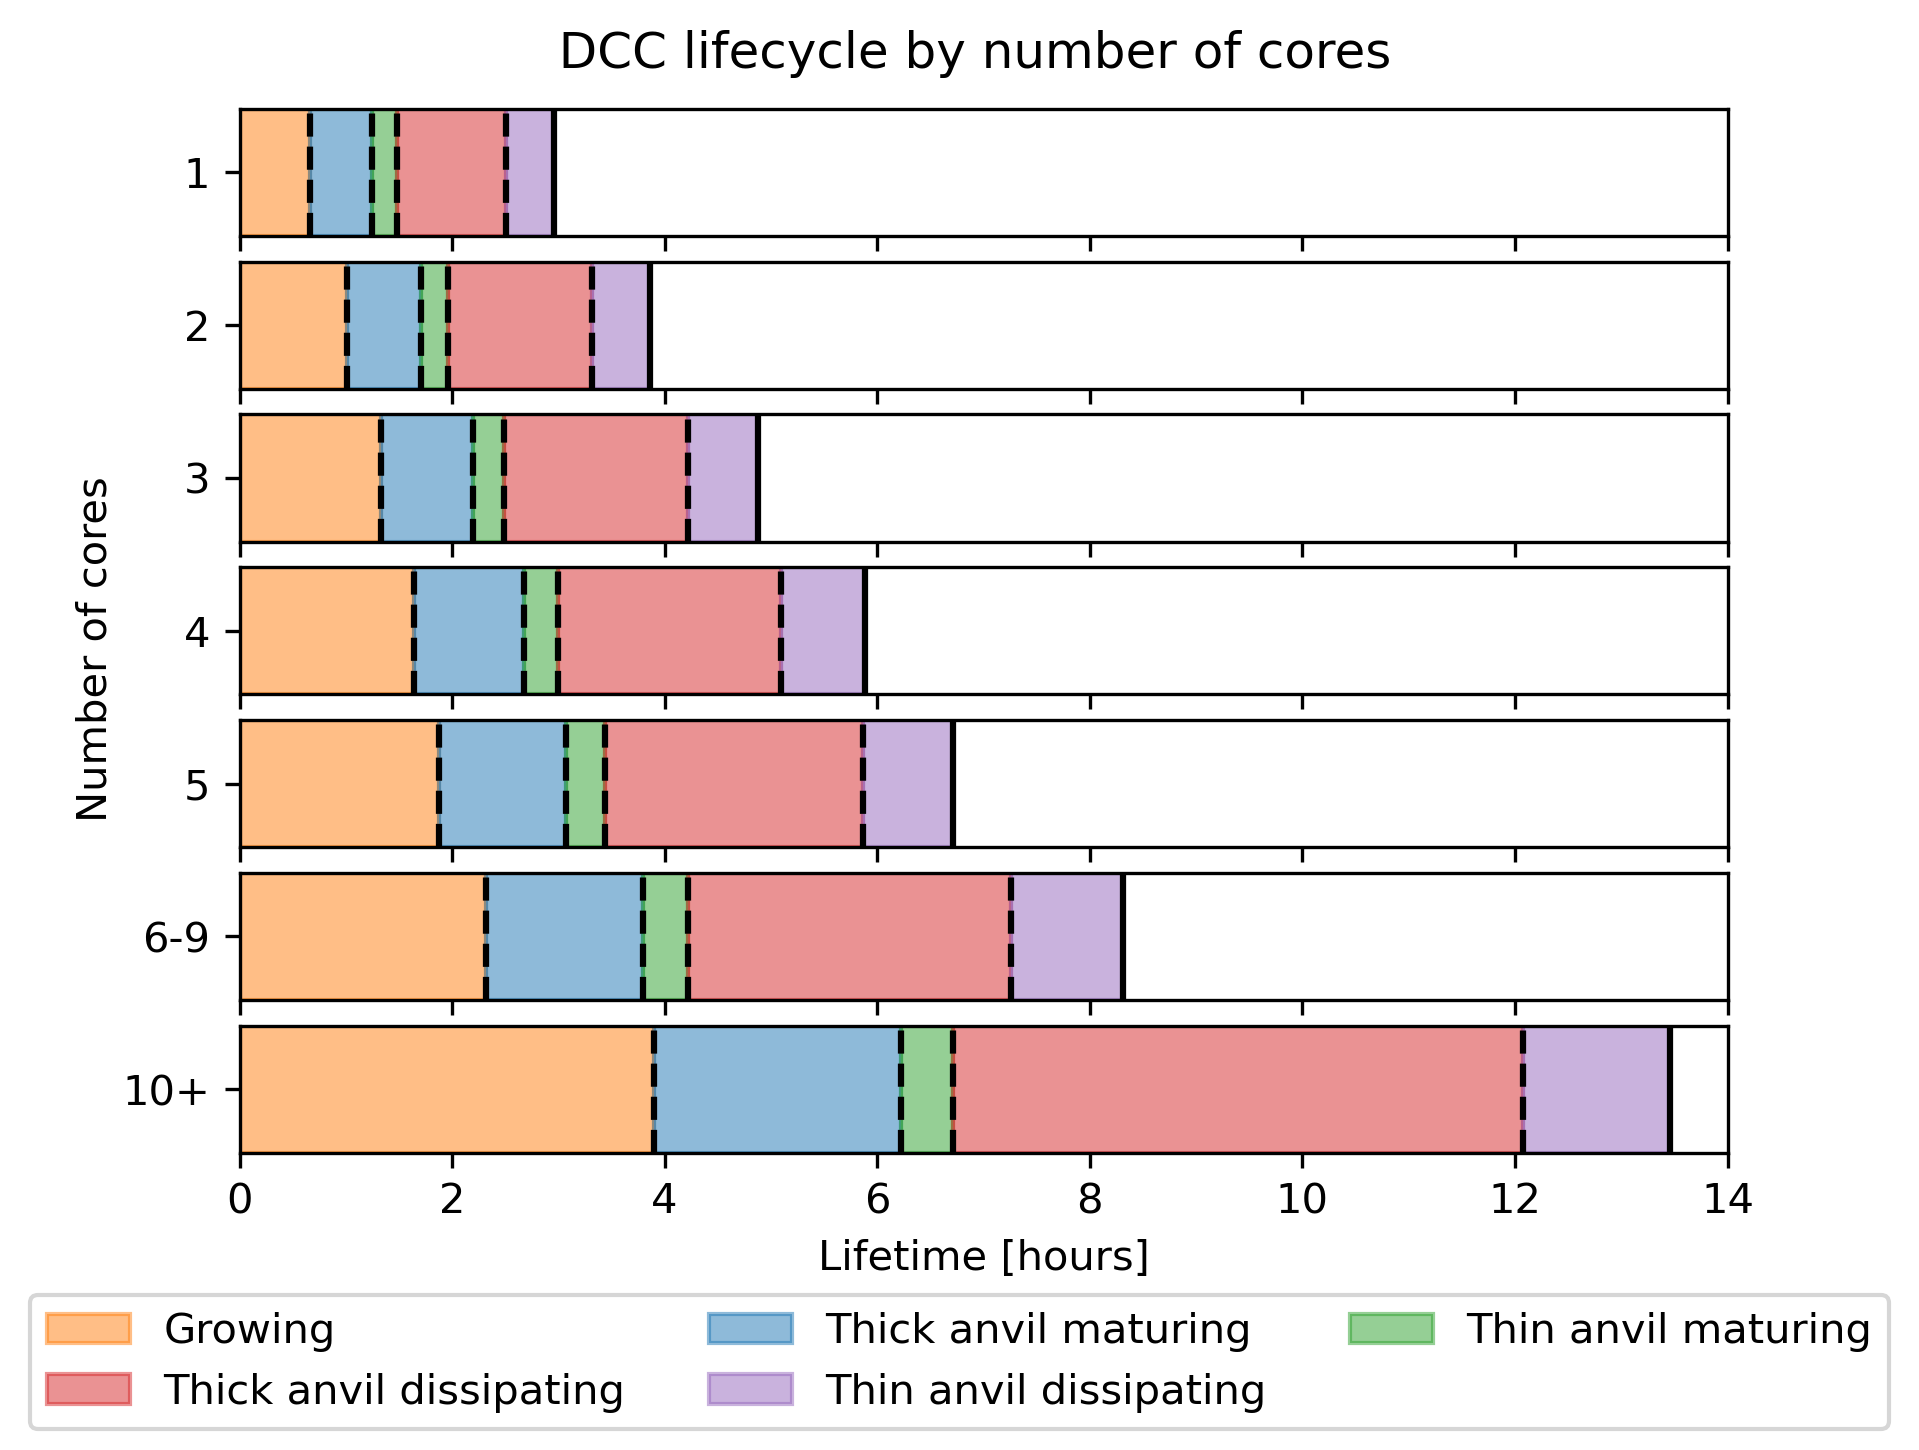

In [29]:
fig, axes = plt.subplots(7, 1, sharex=True, dpi=dpi)

for i in range(1,8):
    if i==6:
        wh = np.logical_and(anvil_number_of_cores>=6, anvil_number_of_cores<=9)
        ylabel = ["6-9"]
    elif i==7:
        wh = anvil_number_of_cores>=10
        ylabel = ["10+"]
    else:
        wh = anvil_number_of_cores==i
        ylabel = [str(i)]

    wh = np.logical_and(wh, anvil_is_valid)
        
    ax = axes[i-1]
    
    min_bt_t = np.nanmean(anvil_time_to_min_BT[wh])
    max_thick_area_t = np.nanmean(anvil_time_to_max_thick_area[wh])
    max_thin_area_t = np.nanmean(anvil_time_to_max_thin_area[wh])
    thick_lifetime_t = np.nanmean(thick_anvil_lifetime[wh])
    thin_lifetime_t = np.nanmean(thin_anvil_lifetime[wh])
    
    f1 = ax.fill_between([0,min_bt_t],[0,0],[1,1],color="C1",alpha=0.5)
    ax.axvline(x=min_bt_t, color='k', linestyle="--", linewidth=1.5)
    
    f2 = ax.fill_between([min_bt_t, max_thick_area_t],[0,0],[1,1],
                    color="C0",alpha=0.5)
    ax.axvline(x=max_thick_area_t, color='k', linestyle="--", linewidth=1.5)
    
    f3 = ax.fill_between([max_thick_area_t, max_thin_area_t],[0,0],[1,1],
                    color="C2",alpha=0.5)
    ax.axvline(x=max_thin_area_t, color='k', linestyle="--", linewidth=1.5)
    
    f4 = ax.fill_between([max_thin_area_t, thick_lifetime_t],[0,0],[1,1],
                    color="C3",alpha=0.5)
    ax.axvline(x=thick_lifetime_t, color='k', linestyle="--", linewidth=1.5)
    
    f5 = ax.fill_between([thick_lifetime_t, thin_lifetime_t],[0,0],[1,1],
                    color="C4",alpha=0.5)
    ax.axvline(x=thin_lifetime_t, color='k', linestyle="-", linewidth=1.5)
    
    ax.set_xlim([0,14])
    ax.set_yticks([0.5], ylabel)
    ax.set_ylim([0,1])

    # print(1 - thick_lifetime_t/thin_lifetime_t)

plt.xlabel("Lifetime [hours]")

plt.suptitle("  DCC lifecycle by number of cores")

fig.legend(
    [f1,f4,f2,f5,f3], 
    ["Growing", "Thick anvil dissipating", "Thick anvil maturing", "Thin anvil dissipating", "Thin anvil maturing"],
    loc="lower center", ncol=3
)

plt.subplots_adjust(left=0.125, top=0.925,  bottom=0.2)

fig.text(0.05, 0.55, "Number of cores", rotation="vertical", ha="center", va="center")

figure_list.append(plt.gcf())

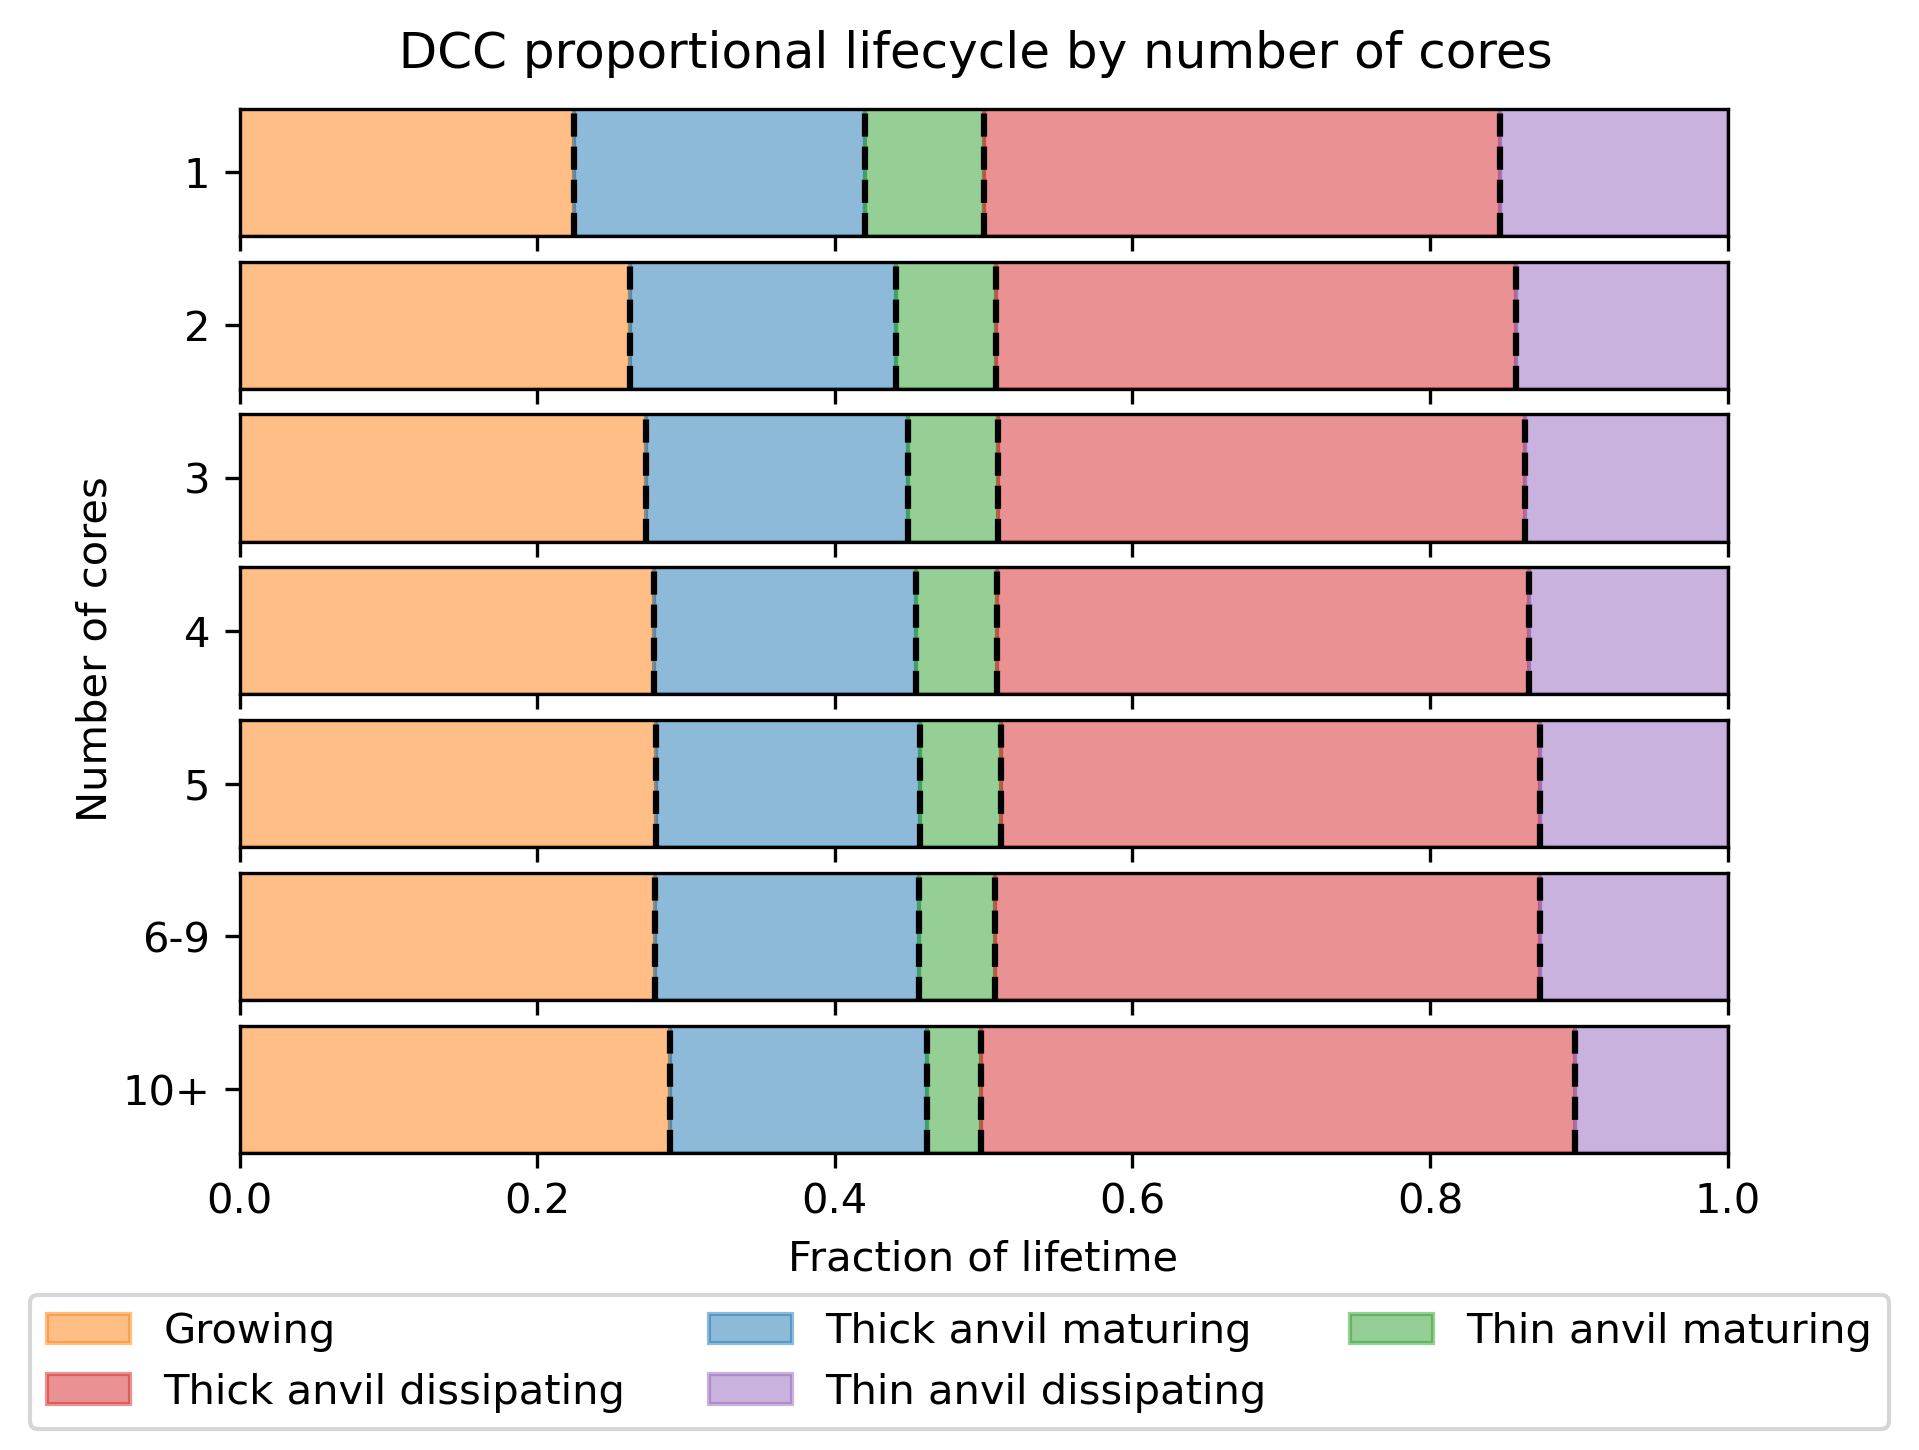

In [30]:
fig, axes = plt.subplots(7, 1, sharex=True, dpi=dpi)

for i in range(1,8):
    if i==6:
        wh = np.logical_and(anvil_number_of_cores>=6, anvil_number_of_cores<=9)
        ylabel = ["6-9"]
    elif i==7:
        wh = anvil_number_of_cores>=10
        ylabel = ["10+"]
    else:
        wh = anvil_number_of_cores==i
        ylabel = [str(i)]

    wh = np.logical_and(wh, anvil_is_valid)
        
    ax = axes[i-1]
    
    min_bt_t = np.nanmean(anvil_time_to_min_BT[wh])
    max_thick_area_t = np.nanmean(anvil_time_to_max_thick_area[wh])
    max_thin_area_t = np.nanmean(anvil_time_to_max_thin_area[wh])
    thick_lifetime_t = np.nanmean(thick_anvil_lifetime[wh])
    thin_lifetime_t = np.nanmean(thin_anvil_lifetime[wh])
    
    f1 = ax.fill_between([0,min_bt_t/thin_lifetime_t],[0,0],[1,1],color="C1",alpha=0.5)
    ax.axvline(x=min_bt_t/thin_lifetime_t, color='k', linestyle="--", linewidth=1.5)
    
    f2 = ax.fill_between([min_bt_t/thin_lifetime_t, max_thick_area_t/thin_lifetime_t],[0,0],[1,1],
                    color="C0",alpha=0.5)
    ax.axvline(x=max_thick_area_t/thin_lifetime_t, color='k', linestyle="--", linewidth=1.5)
    
    f3 = ax.fill_between([max_thick_area_t/thin_lifetime_t, max_thin_area_t/thin_lifetime_t],[0,0],[1,1],
                    color="C2",alpha=0.5)
    ax.axvline(x=max_thin_area_t/thin_lifetime_t, color='k', linestyle="--", linewidth=1.5)
    
    f4 = ax.fill_between([max_thin_area_t/thin_lifetime_t, thick_lifetime_t/thin_lifetime_t],[0,0],[1,1],
                    color="C3",alpha=0.5)
    ax.axvline(x=thick_lifetime_t/thin_lifetime_t, color='k', linestyle="--", linewidth=1.5)
    
    f5 = ax.fill_between([thick_lifetime_t/thin_lifetime_t, 1],[0,0],[1,1],
                    color="C4",alpha=0.5)
    
    ax.set_xlim([0,1])
    ax.set_yticks([0.5], ylabel)
    ax.set_ylim([0,1])

plt.xlabel("Fraction of lifetime")

plt.suptitle("  DCC proportional lifecycle by number of cores")

fig.legend(
    [f1,f4,f2,f5,f3], 
    ["Growing", "Thick anvil dissipating", "Thick anvil maturing", "Thin anvil dissipating", "Thin anvil maturing"],
    loc="lower center", ncol=3
)

plt.subplots_adjust(left=0.125, top=0.925,  bottom=0.2)

fig.text(0.05, 0.55, "Number of cores", rotation="vertical", ha="center", va="center")

figure_list.append(plt.gcf())

In [31]:
interp_proportions = 1 - (np.maximum(interp_thick_areas, interp_core_areas) / np.maximum(interp_thin_areas, interp_core_areas))

In [32]:
from matplotlib import colormaps

## Composite proportion vs cooling rate

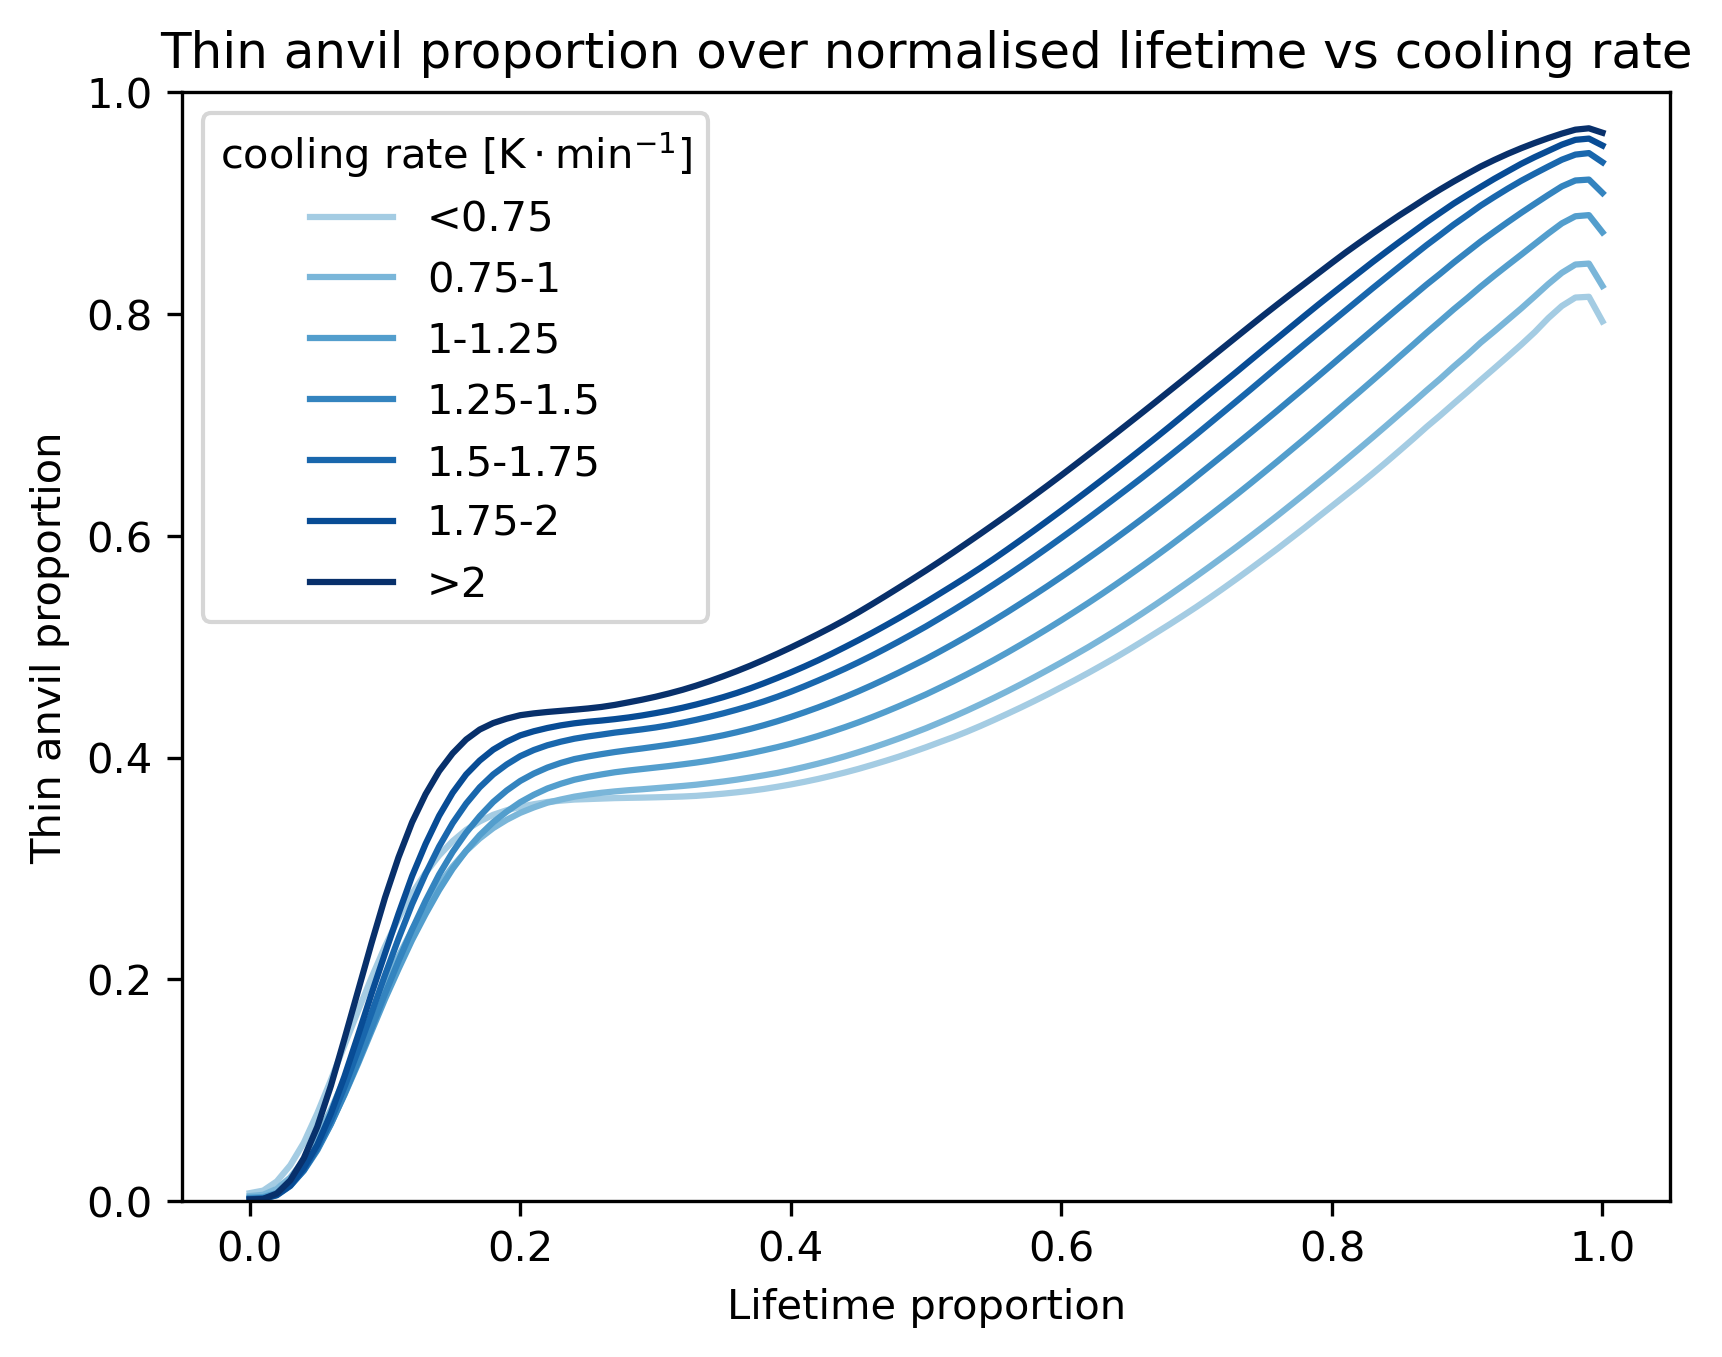

In [33]:
plt.figure(dpi=dpi)

for i in range(1,8):
    wh = np.logical_and(
        initial_core_cooling_rate >= anvil_cooling_bins[i-1], 
        initial_core_cooling_rate < anvil_cooling_bins[i]
    )
        
    wh = np.logical_and(wh, anvil_is_valid)

    plt.plot(
        np.linspace(0,1,101),
        interp_proportions[wh].mean(0), color=colormaps.get_cmap("Blues")((i/7)*0.75 + 0.25)
    )

plt.legend(anvil_cooling_labels, title="cooling rate [$\mathrm{K \cdot min^{-1}}$]")
plt.ylim(0,1)
plt.ylabel("Thin anvil proportion")
plt.xlabel("Lifetime proportion")
plt.title("Thin anvil proportion over normalised lifetime vs cooling rate")

figure_list.append(plt.gcf())

## Composite proportion vs number of cores

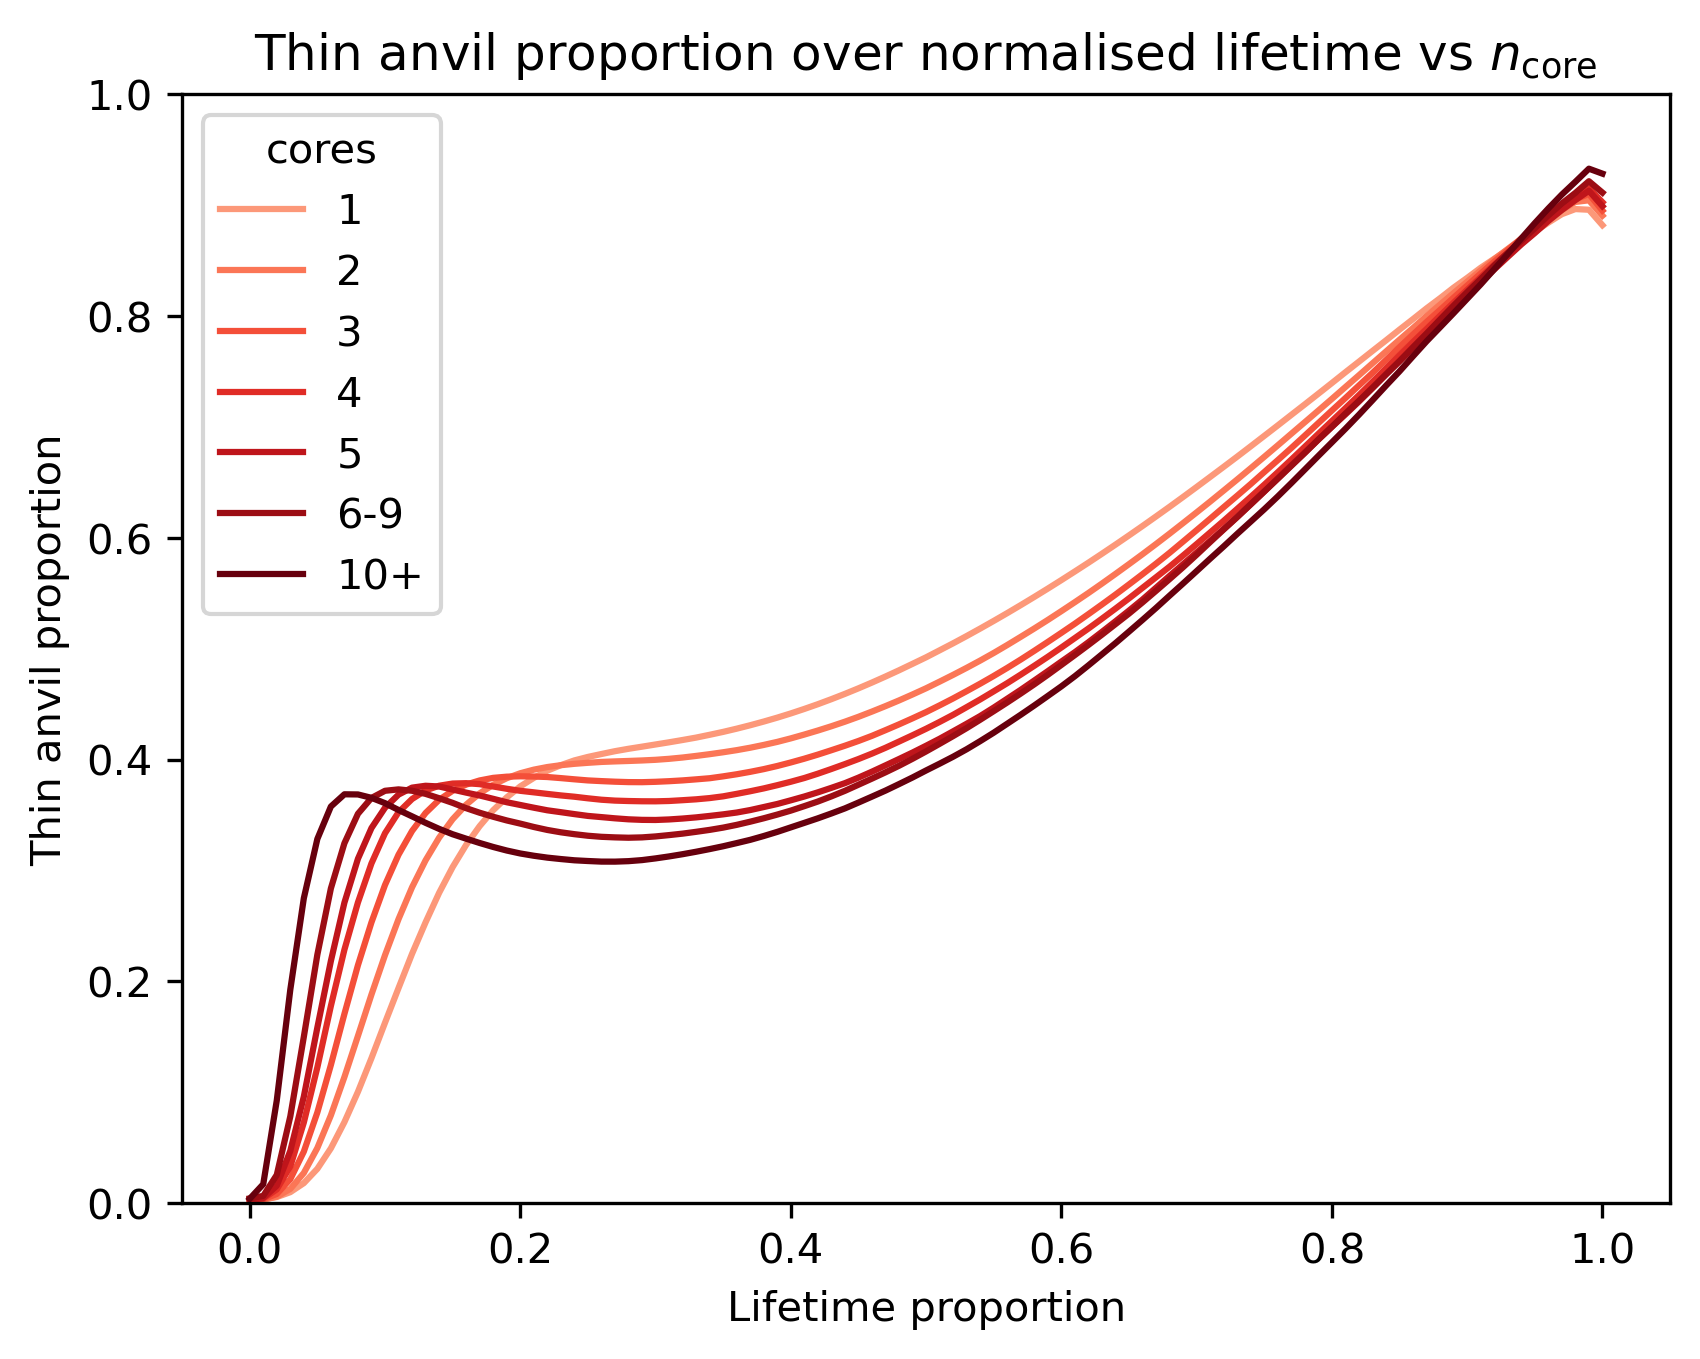

In [34]:
plt.figure(dpi=dpi)

for i in range(1,8):
    if i==6:
        wh = np.logical_and(anvil_number_of_cores>=6, anvil_number_of_cores<=9)
        ylabel = ["6-9"]
    elif i==7:
        wh = anvil_number_of_cores>=10
        ylabel = ["10+"]
    else:
        wh = anvil_number_of_cores==i
        ylabel = [str(i)]

    wh = np.logical_and(wh, anvil_is_valid)
    
    plt.plot(
        np.linspace(0,1,101),
        interp_proportions[wh].mean(0), color=colormaps.get_cmap("Reds")((i/7)*0.75 + 0.25)
    )

plt.legend(bin_labels, title="cores")
plt.ylim(0,1)
plt.ylabel("Thin anvil proportion")
plt.xlabel("Lifetime proportion")
plt.title("Thin anvil proportion over normalised lifetime vs $n_\mathrm{core}$")

figure_list.append(plt.gcf())

In [35]:
for i, fig in enumerate(figure_list):
    fig.savefig(
        save_path / f'{chapter_name}_{(i+1):02d}.{save_format}',
        bbox_inches="tight", pad_inches=0.25
    )